In [82]:

%config Completer.use_jedi = False
import numpy as np
from numba import jit,njit
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
from scipy import sparse
import skimage
import tifffile as tiff
import os
import math
import operator
from com import *
from skeleton import *
from tqdm.notebook import tqdm

In [83]:

imgspath = r"/media/isis0517/QVO2/200503_SIDE_FEMALE_02"
#imgspath = r"/media/isis0517/QVO2/0511/01"
#imgspath = "/home/isis0517/Documents/data/imgs"

def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(imgspath)
flist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(flist))
data_len = len(flist)//2


80000


(500, 2000)


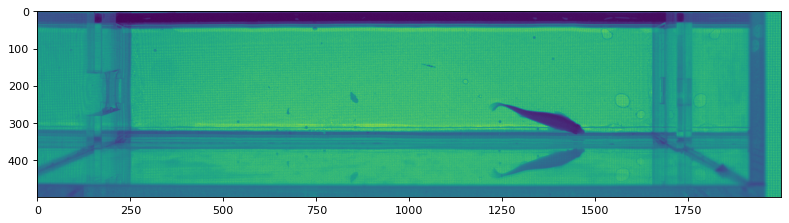

In [84]:
test_frame = np.load(os.path.join(imgspath, flist[25718+data_len]))
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(test_frame)
print(test_frame.shape)

In [86]:

%%script false --no-raise-error
video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (1200,800))
for s in tqdm(range(data_len//20)):
    
    b = cv2.resize(np.load(os.path.join(imgspath, flist[s+data_len])), (1200,400))
    b = cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
    a = cv2.resize(a, (1200,400))
    video.write(np.concatenate((b, a), axis=0))
video.release()
plt.imshow(a)


# 找出ZebraPCA

## 產生背景

In [87]:
tnum = np.random.randint(data_len,size = data_len//10)
a = np.load(os.path.join(imgspath, flist[10+data_len]))
background = np.zeros(a.shape)
for s in tqdm(tnum):
    a = np.load(os.path.join(imgspath, flist[s+data_len]))
    a = cv2.blur(a, ksize=(3, 3))
    background += a
background = background/len(tnum)
background = background.astype('uint8')


  0%|          | 0/4000 [00:00<?, ?it/s]

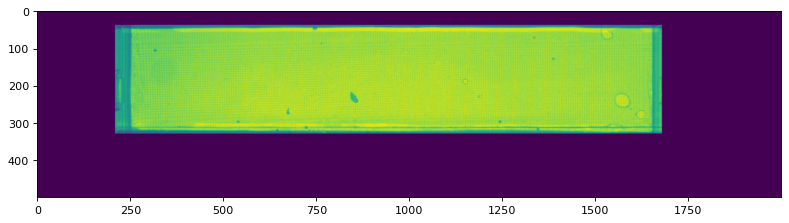

In [88]:
mask = np.full(background.shape, False)
#mask[93:400,5:1480]=True
mask[40:330,210:1680]=True
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(background*mask)

## 轉正圖片 & 儲存

### multi ver

In [89]:
%%time

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

from multiprocessing import Pool
from numba import jit, njit
from skimage.measure import label

abs_lim = 80
def multi_rot_imgs(filename, background, mask, abs_lim):
    size = 120
    img = np.load(filename)
    img = cv2.absdiff(img, background)
    img = img*mask
    img = np.where(img>abs_lim, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, size)

    labels = label(img, connectivity=2, background=False)
    group = regionprops(labels)

    index = 0
    area = 0
    for com in group:
        if com.area > area:
            index = com.label
            area = com.area
    img = np.where(labels==index, 255, 0).astype('uint8')
    
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        return s
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1, 0])  # x, y
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    
    err = b-np.dot(get_rot_M(-angle), a) 
    b_len = np.linalg.norm(b)
    while np.linalg.norm(err) > b_len*0.1:
        angle=-angle
        err = b-np.dot(get_rot_M(-angle), a)
        
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((size, size), -angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (2*size+1,2*size+1))
    
    return rotated, angle, pos


with Pool() as pool:
    map_arr = []
    for s in range(data_len):
        path = os.path.join(imgspath, flist[s+data_len])
        map_arr.append((path, background, mask, abs_lim))
    print("pool start")
    result = pool.starmap(multi_rot_imgs, map_arr)

imgs = []
h_ans = []
poses = []
print("stop")
for temp in result:
    imgs.append(temp[0])
    h_ans.append(temp[1])
    poses.append(temp[2])

pool start
stop
CPU times: user 2.36 s, sys: 2.38 s, total: 4.74 s
Wall time: 3min 32s


76.26373169437743 [199 137]


(-0.5, 240.5, 240.5, -0.5)

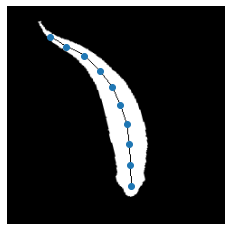

In [90]:
s = 1020   
sk = NT_skeleton(imgs[s], er_num=2, di_num=3)

draw = imgs[s].copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
print(h_ans[s]/(np.pi)*180, sk[0])
plt.imshow(draw, plt.cm.gray)
plt.scatter(sk[:,1], sk[:,0])
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

### save as video

In [9]:
%%script false --no-raise-error
video = cv2.VideoWriter("path.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (background.shape[1], background.shape[0]))

for s in tqdm(range(data_len)):
    draw = np.load(os.path.join(imgspath, flist[s+data_len]))
    draw = cv2.cvtColor(draw, cv2.COLOR_GRAY2RGB)
    cv2.circle(draw, (poses[s][1], poses[s][0]), 3, (255,0,0), -1)
    video.write(draw)
video.release()

## apply the eigenfish

In [91]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)



han_sks=[]

for s, img in enumerate(tqdm(imgs)):
    try:
        sk = NT_skeleton(img, er_num=2, di_num=3)
    except Exception as e:
        print(s)
        raise e
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print("sk error")
        print(s, NT_skeleton(imgs[s]))
        plt.show()
        break
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
            break
        
        err = b-np.dot(get_rot_M(angle), a) 
        b_len = np.linalg.norm(b)
        while np.linalg.norm(err) > b_len*0.1:
            angle=-angle
            err = b-np.dot(get_rot_M(angle), a)
            
        han_sk.append(angle)
    han_sks.append(han_sk)
print(len(han_sks))    


## 20000張 1:25

  0%|          | 0/40000 [00:00<?, ?it/s]

40000


In [11]:
%%script false --no-raise-error
def NT_skeleton_t(img, **kwargs):
    """

    :param img: the img of the zebrafish, it must be uint8 with 1 channel img
    :kwargs
        er_num: the number of iteration for erode.
        di_num: the number of iteration for dilate.
        sk_num: the number of node in skeleton.
    :return sk: The skeleton of fish
    """

    sk_num = kwargs.setdefault('sk_num', 10)
    ekernel = np.array([[0, 1, 0],
                        [1, 0, 1],
                        [0, 1, 0]], dtype='uint8')
    assert img.dtype == 'uint8' or img.dtype == np.uint8, "it is not uint8"

    img = pre_img(img, **kwargs)
    labels = label(img, connectivity=1, background=0)
    group = regionprops(labels, cache=True)

    n, index = 0, 0
    area = 0
    for com in group:
        if com.area > area:
            index = n
            area = com.area
    com = group[index]

    # the minimums box contain all points of the img
    min_row, min_col, max_row, max_col = com.bbox
    # sub = img[min_row:max_row, min_col:max_col]

    min_row = min_row - 2
    min_col = min_col - 2
    max_row = max_row + 2
    max_col = max_col + 2

    # sub = np.pad(sub,((2,2),(2,2)),'constant',constant_values = (0,0))

    # the minimums box's size
    row, col = (max_row - min_row, max_col - min_col)
    points = com.coords - np.array([min_row, min_col])

    sub = np.zeros((row, col), dtype=np.uint8)
    sub[points[:, 0], points[:, 1]] = 255
    # cut to smallest size
    erosion = cv2.erode(sub, ekernel, iterations=1)
    height = cv2.distanceTransform(erosion, cv2.DIST_L2, 3)[points[:, 0], points[:, 1]]

    not_known = erosion > 100
    is_bound = np.logical_xor(erosion, sub)

    # points

    points_ord = np.argsort(height)

    U, count = find_U(is_bound, points[points_ord], not_known)  # 0.3ms

    result = find_cen(U, count)  # 1ms
    result = result * (erosion > 100)
    
    labels = label(result, connectivity=2, background=False)
    group = regionprops(labels)

    index = 0
    area = 0
    for com in group:
        print(com.area)
        if com.area > area:
            index = com.label
            area = com.area
    result = labels==index
    
    point = np.nonzero(result)
    point = list(zip(point[0], point[1]))

    skeleton = find_ske(result, point, sub, sim_num=sk_num) + np.array([min_row, min_col])

    return skeleton


In [12]:
%%script false --no-raise-error
s = 17560   
img = pre_img(imgs[s])
sk = NT_skeleton_t(imgs[s], er_num=2, di_num=3)
print(sk)
draw = img.copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

## find the pca

[0.85143753 0.11609493 0.02252834] 0.9900608050680216


(-2.9582027345607944,
 10.617057273074323,
 -8.889955305901164,
 -0.6242878425761349)

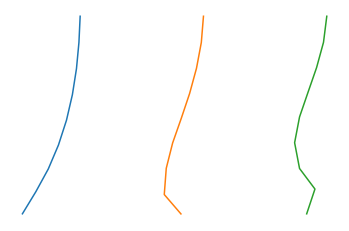

In [13]:

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(han_sks)
pc1 = pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = pca.transform(han_sks)
plt.axis("off")

# Kmeans

In [14]:
from sklearn.cluster import KMeans

n_clusters = 23
pos_kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-11, n_init=40)
pos_kmeans.fit(pca_sks)
labels = pos_kmeans.predict(pca_sks)
centers = pos_kmeans.cluster_centers_

## order by tail position

In [15]:
temp = []
for pcas in centers:
    sks = np.dot(pcas, pca.components_)
    sk = [np.array([0,-2])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    print(sks)
    temp.append(np.average(sks, weights=np.abs(len(sks)-0.5-np.arange(len(sks)))))
ords = np.argsort(temp)

[-0.03405589 -0.082159   -0.09535625 -0.07842921 -0.00509265  0.16517037
  0.39541241  0.6636457 ]
[-0.14417044 -0.29748689 -0.46331795 -0.63067242 -0.7920049  -0.88826396
 -0.97037534 -1.00639602]
[0.17236904 0.34544341 0.56638273 0.81563918 1.10552391 1.3884495
 1.70328398 1.97856977]
[ 0.05671607  0.12904567  0.16813386  0.17709518  0.12827583 -0.0283598
 -0.24778376 -0.51535689]
[0.03771784 0.0780486  0.12142156 0.1650132  0.20675694 0.23093256
 0.25047954 0.24603815]
[0.13713402 0.2823093  0.44045923 0.60090547 0.75703816 0.85367655
 0.93972871 1.00842714]
[-0.06779337 -0.13979878 -0.218905   -0.29972023 -0.37959775 -0.43140729
 -0.47722873 -0.47884962]
[-0.28675069 -0.58200647 -0.93074916 -1.30551253 -1.70951858 -2.04590301
 -2.3997145  -2.73888132]
[ 0.25958166  0.59459747  1.00237253  1.45679205  2.00594002  2.52371301
  2.79675497 -2.94365182]
[-0.25331685 -0.58239096 -0.98067482 -1.42310658 -1.9560659  -2.45407053
 -2.70434149  3.04117525]
[-0.084492   -0.15888232 -0.29320055

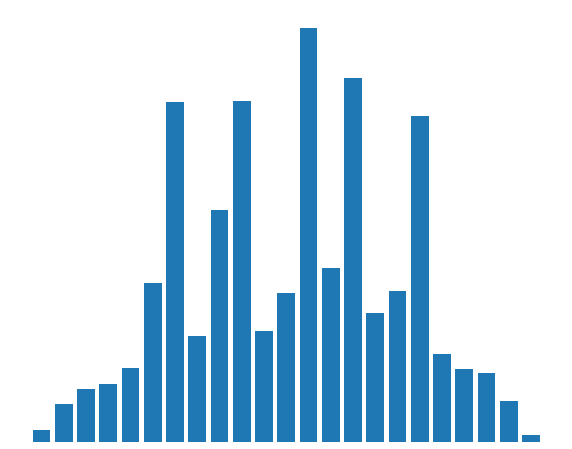

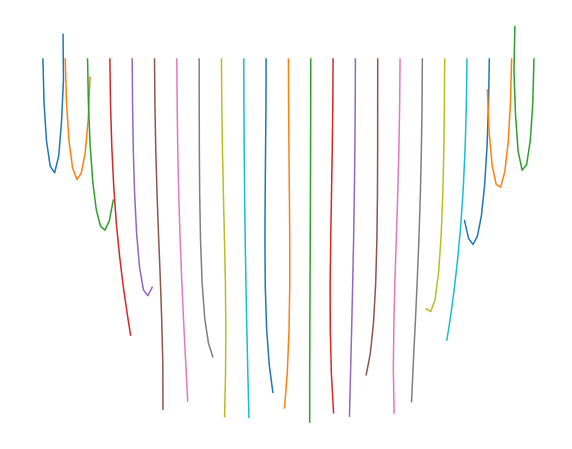

In [16]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
u = np.array([0,-1])

plt.figure(figsize=(10,8))

plt.bar(bins[:-1], nums[ords])
plt.axis('off')
plt.show()
plt.figure(figsize=(10,8))

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M, sk[0]))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.xlim([-8, n_clusters*5+2])
plt.show()

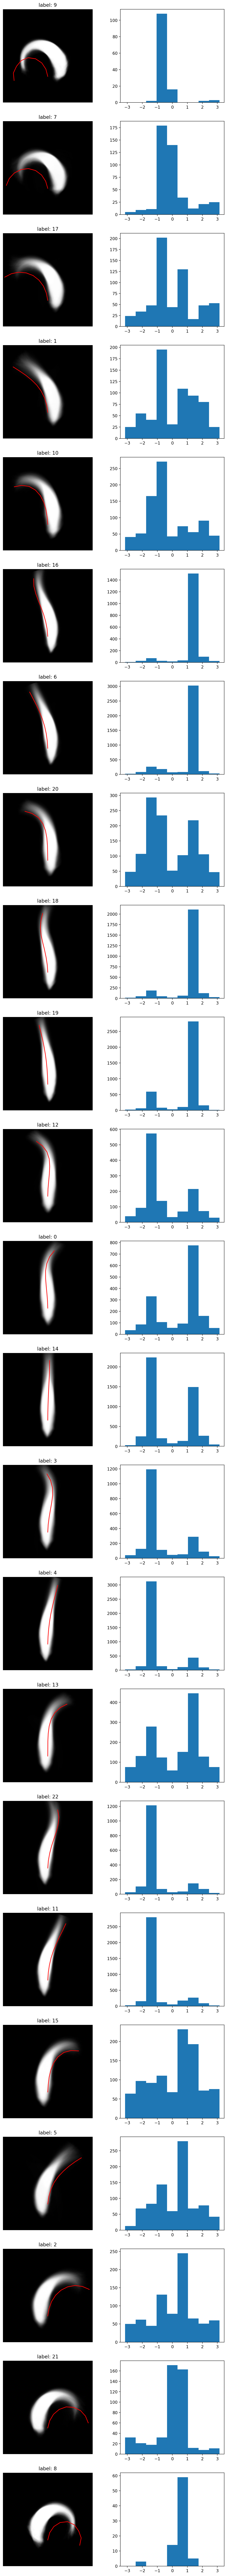

In [17]:
fig, axs = plt.subplots(pos_kmeans.n_clusters, 2, figsize=(10,5*pos_kmeans.n_clusters), dpi= 200)
ans = [list() for _ in range(pos_kmeans.n_clusters)]
cen_imgs = np.zeros((n_clusters, imgs[0].shape[0], imgs[0].shape[1]), dtype='int')

bins = np.linspace(-np.pi, np.pi, num=10)

for s, label in enumerate(labels):
    cen_imgs[label] += imgs[s]
    ans[label].append(h_ans[s])

for num, s in enumerate(ords):
    img = cen_imgs[s]
    cen_imgs[s] = (img/nums[s]).astype('uint8')
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    
    sks = np.dot(centers[s], pca.components_)
    sk = [np.array([0,2])]
    for an in sks:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M, sk[0]))
    sk = np.array(sk)
    
    axs[num, 0].imshow(cen_imgs[s], plt.cm.gray, extent=[-12, 12, -5, 20]) 
    axs[num, 0].title.set_text(f"label: {s}")
    axs[num, 0].plot(sk[:,0], sk[:,1], c='red')
    axs[num, 0].axis('Off')
    
    axs[num, 1].hist(ans[s], bins=bins)

# for s, _ in np.ndenumerate(axs):
#     axs[s].axis('Off')

['g' 'g' 'g' 'g' 'g' 'r' 'r' 'g' 'r' 'r' 'g' 'g' 'g' 'b' 'b' 'g' 'b' 'b'
 'g' 'g' 'g' 'g' 'r']


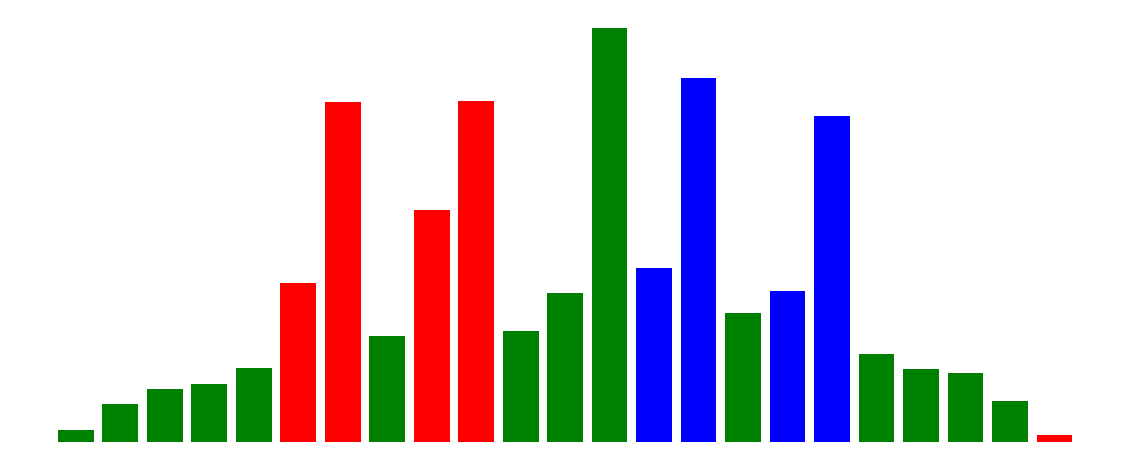

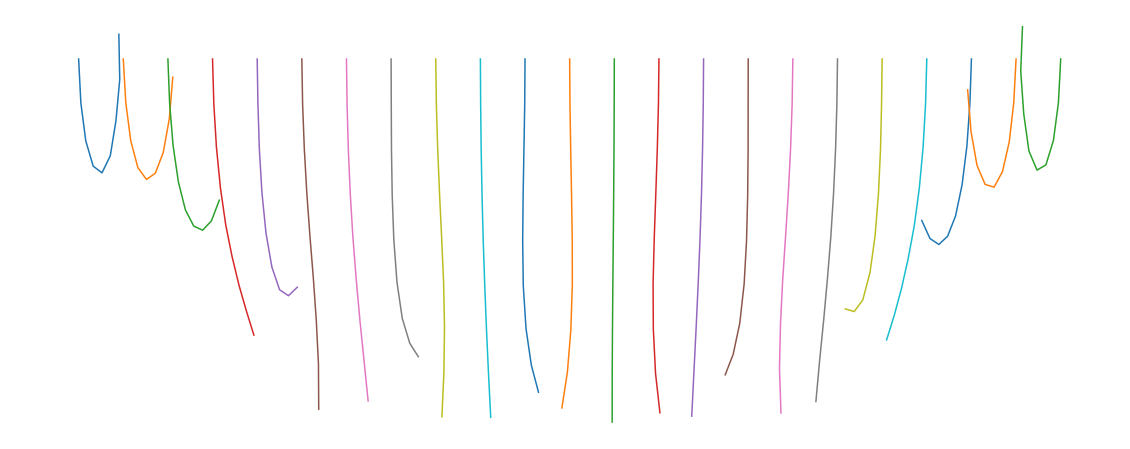

In [18]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
u = np.array([0,-1])

color = []
for an in ans:
    if np.mean(an) > 0.5:
        color.append('r')
    elif np.mean(an) < -0.5:
        color.append('b')
    else:
        color.append('g')
color = np.array(color)
print(color[ords])
plt.figure(figsize=(20,8))

plt.bar(bins[:-1], nums[ords], color=color[ords])
plt.axis('off')
plt.show()
plt.figure(figsize=(20,8))

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M, sk[0]))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.xlim([-8, n_clusters*5+2])
plt.show()

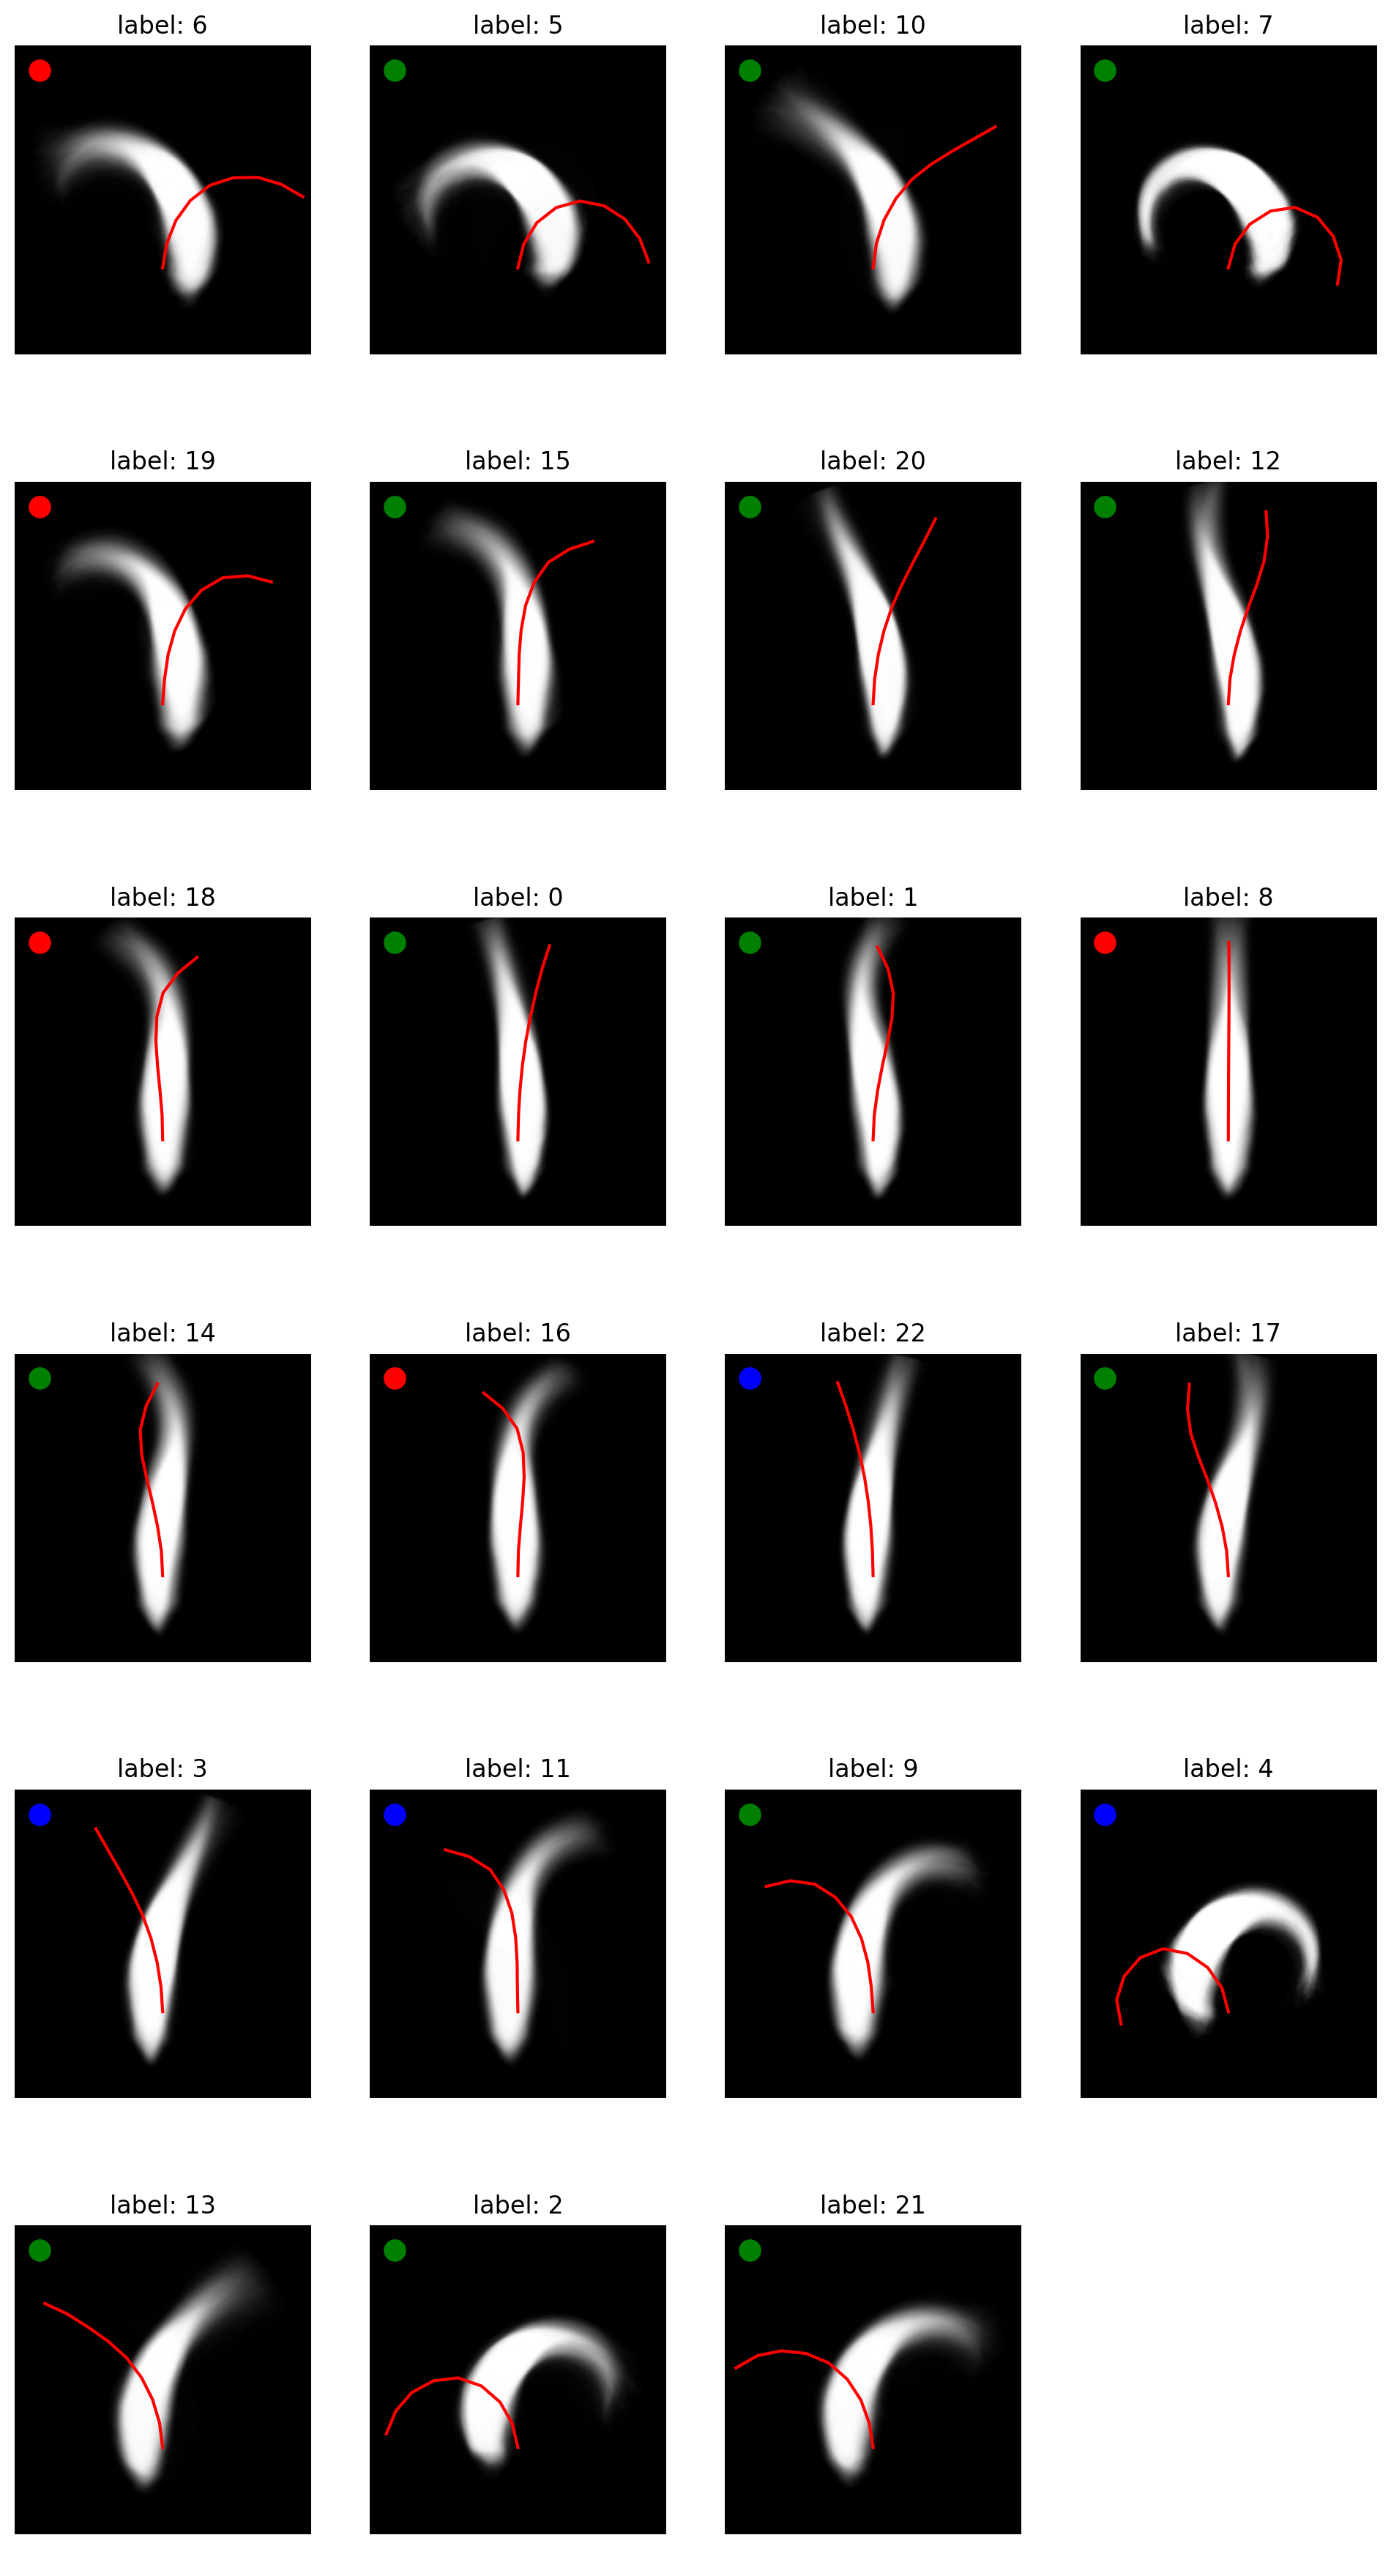

In [80]:
fig, axs = plt.subplots(pos_kmeans.n_clusters//4+1, 4, figsize=(12,1*pos_kmeans.n_clusters), dpi= 200)
ans = [list() for _ in range(pos_kmeans.n_clusters)]
cen_imgs = np.zeros((n_clusters, imgs[0].shape[0], imgs[0].shape[1]), dtype='int')
for s, label in enumerate(labels):
    cen_imgs[label] += imgs[s]

for num, s in enumerate(ords):
    img = cen_imgs[s]
    cen_imgs[s] = (img/nums[s]).astype('uint8')
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    
    sks = np.dot(centers[s], pca.components_)
    sk = [np.array([0,2])]
    for an in sks:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M, sk[0]))
    sk = np.array(sk)
    
    fig = axs[num//4, num%4]
    
    fig.imshow(cen_imgs[s], plt.cm.gray, extent=[-12, 12, -5, 20]) 
    fig.title.set_text(f"label: {s}")
    fig.plot(sk[:,0], sk[:,1], c='red')
    fig.axis('Off')
    fig.scatter(-10, 18, s=100, color=color[s])

for s, _ in np.ndenumerate(axs):
     axs[s].axis('Off')

## summery the angle of each labels

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[-3.14159265 -2.44346095 -1.74532925 -1.04719755 -0.34906585  0.34906585
  1.04719755  1.74532925  2.44346095  3.14159265]


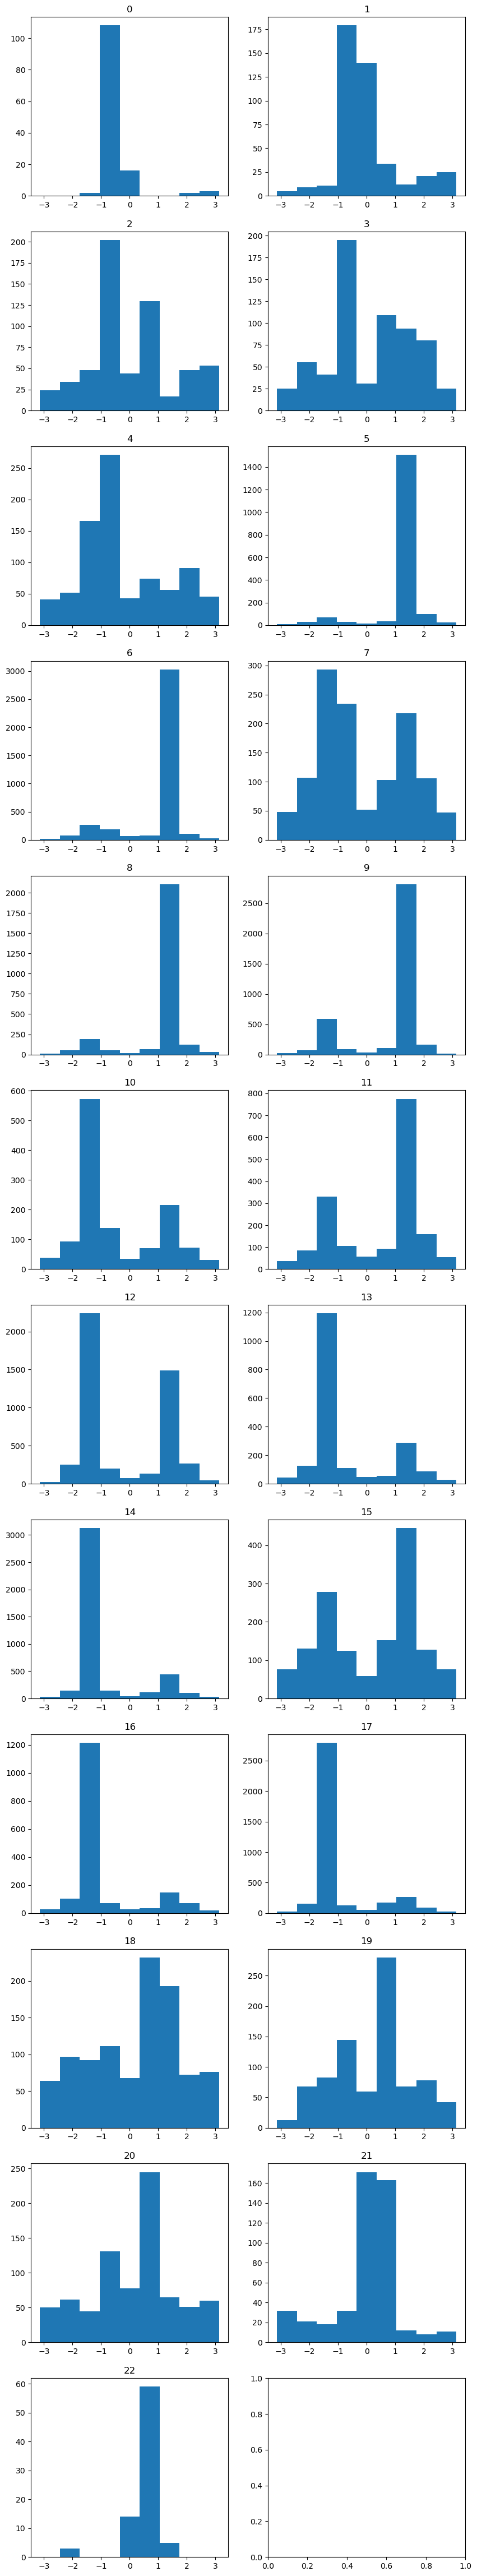

In [20]:
ans = [list() for _ in range(pos_kmeans.n_clusters)]
print(ans)
for s, label in enumerate(labels):
    ans[label].append(h_ans[s])
    
fig, axs = plt.subplots(pos_kmeans.n_clusters//2+1, 2, figsize=(10,60), dpi= 100)
bins = np.linspace(-np.pi, np.pi, num=10)
print(bins)

for s, t_ans in enumerate([ans[t] for t in ords]):
    axs[s//2, s%2].hist(x=t_ans, bins=bins)
    axs[s//2, s%2].title.set_text(f"{s}")


(array([  636.,  1524., 11884.,  4340.,  1306.,  1513.,  5062., 11545.,
         1517.,   673.]),
 array([-3.09035549, -2.46716067, -1.84396586, -1.22077104, -0.59757623,
         0.02561858,  0.6488134 ,  1.27200821,  1.89520303,  2.51839784,
         3.14159265]),
 <BarContainer object of 10 artists>)

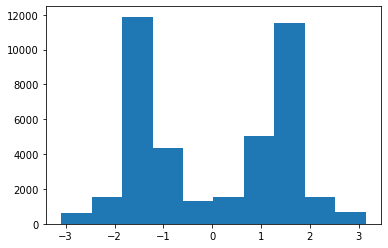

In [21]:
plt.hist(h_ans)

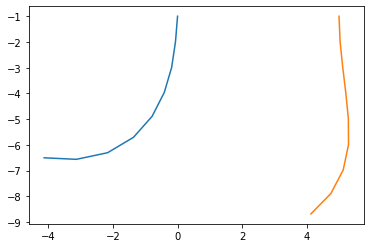

In [22]:
test = [15, 0]

for s, pcas in enumerate(centers[test]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M, sk[0]))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1

## summery the markov matrix

[0.01526718 0.24427481 0.41221374 0.03816794 0.23664122 0.
 0.         0.05343511 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0.01526718 0.24427481 0.41221374 0.03816794 0.23664122 0.
 0.         0.05343511 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


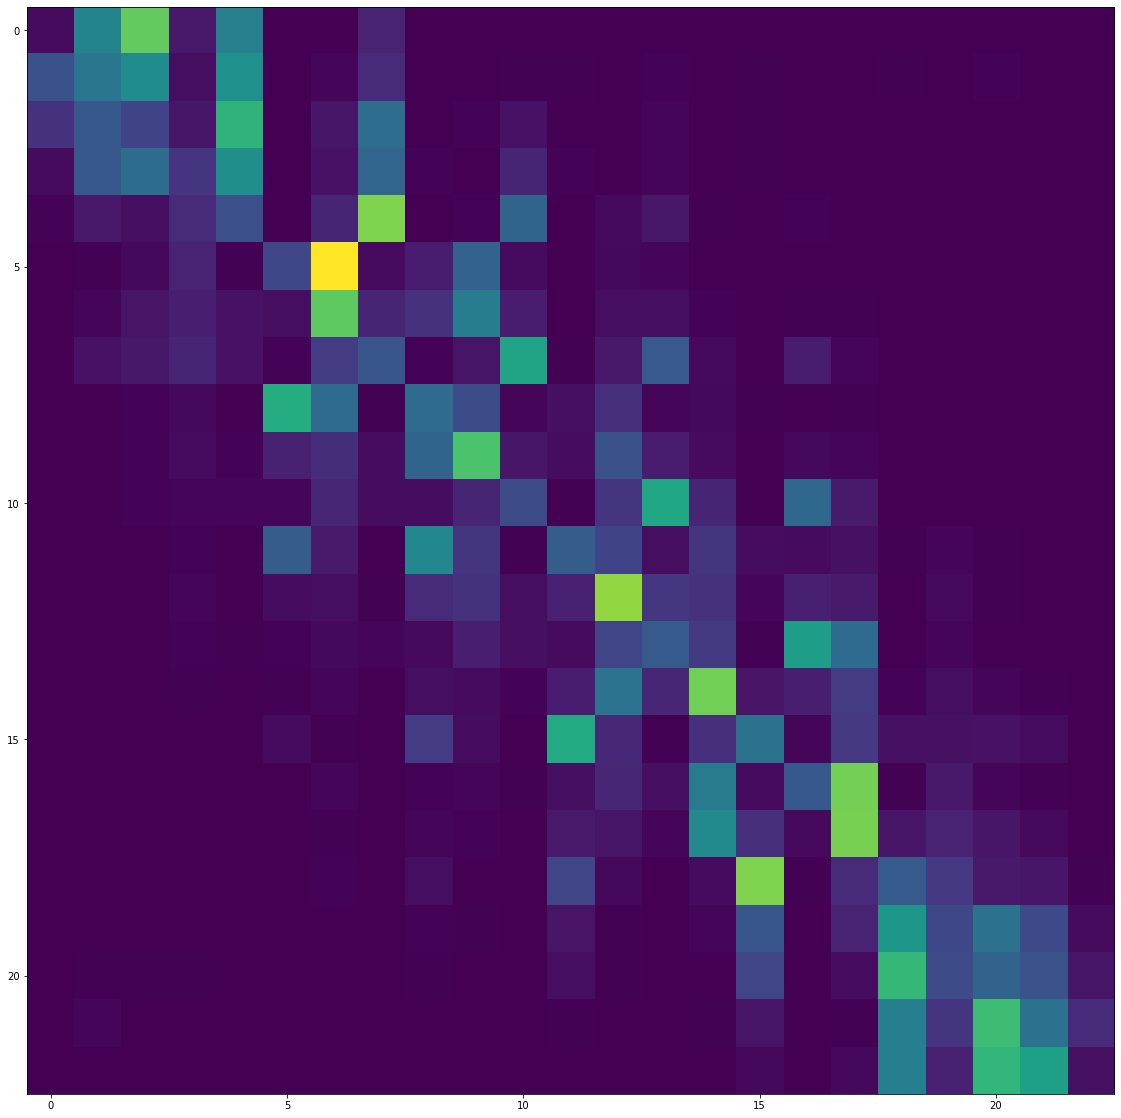

[0.07534712 0.25077303 0.34510287 0.37673349 0.48256446 1.04431694
 2.22658196 0.69479721 1.52269315 2.23603214 0.72753806 0.97736293
 2.71658875 1.13738791 2.38854968 0.84511217 0.98840705 2.13761481
 0.57778666 0.48062784 0.45245621 0.26905764 0.04656793]


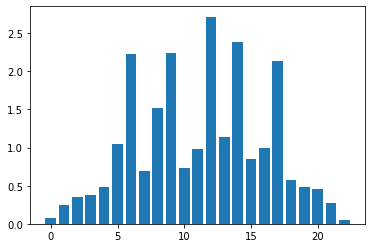

<BarContainer object of 23 artists>

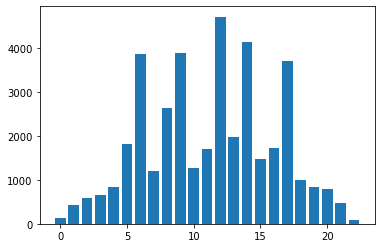

In [23]:
MK = np.zeros((pos_kmeans.n_clusters, pos_kmeans.n_clusters))
for s in range(1, len(labels)):
    label_now = labels[s]
    label_last = labels[s-1]
    
    MK[label_last, label_now] += 1
for s in range(pos_kmeans.n_clusters):
    MK[s, :] = MK[s, :]/np.sum(MK[s, :])

for s in range(pos_kmeans.n_clusters):
    MK[s, :] = MK[s, ords]

for s in range(pos_kmeans.n_clusters):
    MK[:, s] = MK[ords, s]

plt.figure(figsize=(20,20))
plt.imshow(MK[:,:])
arr = [0]*23
arr[0] = 1
print(np.dot(np.array(arr), MK))
print(MK[0,:])
plt.show()

u = [1]*23

for s in range(1000):
    u = np.dot(np.array(u), MK)

print(u)
plt.bar(np.arange(23), u)
plt.show()
plt.bar(np.arange(23), nums[ords])

## 用 MK 產生序列

In [24]:
label_now = 10
new_seq = [label_now]
cen_imgs_mk = cen_imgs[ords]
video = cv2.VideoWriter("MKtest.avi", cv2.VideoWriter_fourcc(*"MJPG"), 20, (cen_imgs[0].shape[0], cen_imgs[0].shape[1]), False)
for s in range(1000):
    #print(cen_imgs[label_now].shape)
    video.write(cen_imgs_mk[label_now].astype(np.uint8))
    ran = np.random.rand()
    n = 0
    temp = MK[label_now, n]
    while temp <= ran:
        n+=1
        temp += MK[label_now, n]
        if n >= n_clusters:
            n=0
            temp = MK[label_now, n]
            ran = np.random.rand()
            
    print(label_now, MK[label_now, n], n)
    label_now = n
    new_seq.append(label_now)

video.release()

10 0.3241106719367589 13
13 0.11324570273003033 12
12 0.08677248677248678 13
13 0.0455005055611729 9
9 0.015432098765432098 14
14 0.20765158806544753 12
12 0.0014814814814814814 21
21 0.0641025641025641 22
22 0.30864197530864196 21
21 0.23504273504273504 18
18 0.08955223880597014 19
19 0.11961722488038277 21
21 0.0811965811965812 19
19 0.20574162679425836 20
20 0.36213468869123255 18
18 0.43781094527363185 15
15 0.33129251700680273 11
11 0.2541176470588235 8
8 0.18995468277945618 6
6 0.019633169723585638 13
13 0.19059656218402427 17
17 0.2584722969338354 14
14 0.09600577478344562 17
17 0.07261968800430339 15
15 0.0945578231292517 8
8 0.3368580060422961 5
5 0.5432506887052342 6
6 0.019633169723585638 13
13 0.19059656218402427 17
17 0.2584722969338354 14
14 0.42829643888354185 14
14 0.04619826756496631 16
16 0.02210587550901687 11
11 0.16117647058823528 11
11 0.08352941176470588 14
14 0.20765158806544753 12
12 0.4552380952380952 12
12 0.01904761904761905 5
5 0.5432506887052342 6
6 0.2286

13 0.09302325581395349 14
14 0.42829643888354185 14
14 0.04619826756496631 16
16 0.42873763816172195 17
17 0.4314147391070468 17
17 0.2584722969338354 14
14 0.42829643888354185 14
14 0.021174205967276226 19
19 0.28827751196172247 18
18 0.06666666666666667 17
17 0.2584722969338354 14
14 0.20765158806544753 12
12 0.08677248677248678 13
13 0.0455005055611729 9
9 0.004372427983539095 4
4 0.4374255065554231 7
7 0.09685430463576158 6
6 0.40867992766726946 6
6 0.22862309480754328 9
9 0.049639917695473254 5
5 0.5432506887052342 6
6 0.22862309480754328 9
9 0.042695473251028807 13
13 0.30434782608695654 16
16 0.225130890052356 14
14 0.20765158806544753 12
12 0.050793650793650794 11
11 0.16058823529411764 5
5 0.17024793388429751 9
9 0.03369341563786008 10
10 0.3241106719367589 13
13 0.004044489383215369 4
4 0.066746126340882 3
3 0.19236641221374046 2
2 0.35333333333333333 4
4 0.03694874851013111 1
1 0.27293577981651373 4
4 0.03694874851013111 1
1 0.27293577981651373 4
4 0.03575685339690107 13
13 

# angle Kmeans

In [25]:
%%time
from sklearn.cluster import KMeans


merge_arr = np.concatenate((np.expand_dims(h_ans, axis=1), pca_sks), axis=1)
n_clusters = 180
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-11, n_init=20)
kmeans.fit(merge_arr)
labels = kmeans.predict(merge_arr)
centers = kmeans.cluster_centers_


CPU times: user 3min 6s, sys: 3min 8s, total: 6min 14s
Wall time: 47 s


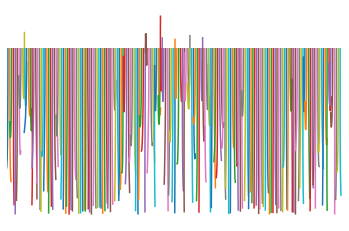

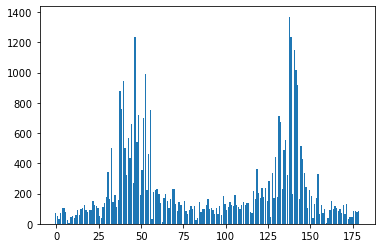

Text(0.5, 0, 'angle')

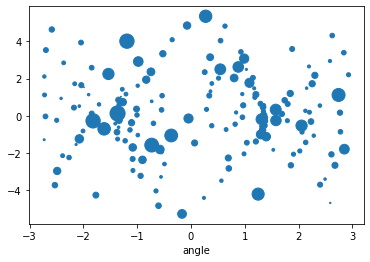

In [26]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(centers[:, 0])[::-1]

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas[1:], pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M,sk[0]))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1

plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()

plt.scatter(*centers[ords][:,0:2].T, marker="o", s=nums/6)
plt.xlabel("angle")

In [27]:
cen_imgs = np.zeros((n_clusters, imgs[0].shape[0], imgs[0].shape[1]), dtype='int')

for s, label in enumerate(labels):
    angle = centers[label, 0]
    M = cv2.getRotationMatrix2D((imgs[s].shape[0]//2, imgs[s].shape[1]//2), -angle/(np.pi)*180, 1)
    img = cv2.warpAffine(imgs[s].copy(), M, tuple(imgs[s].shape[0:2]))
    cen_imgs[label] += img
    
for num, s in enumerate(ords):
    img = cen_imgs[s]
    cen_imgs[s] = (img/nums[s]).astype('uint8')
    
cen_imgs = cen_imgs[ords]

## summery the markov matrix

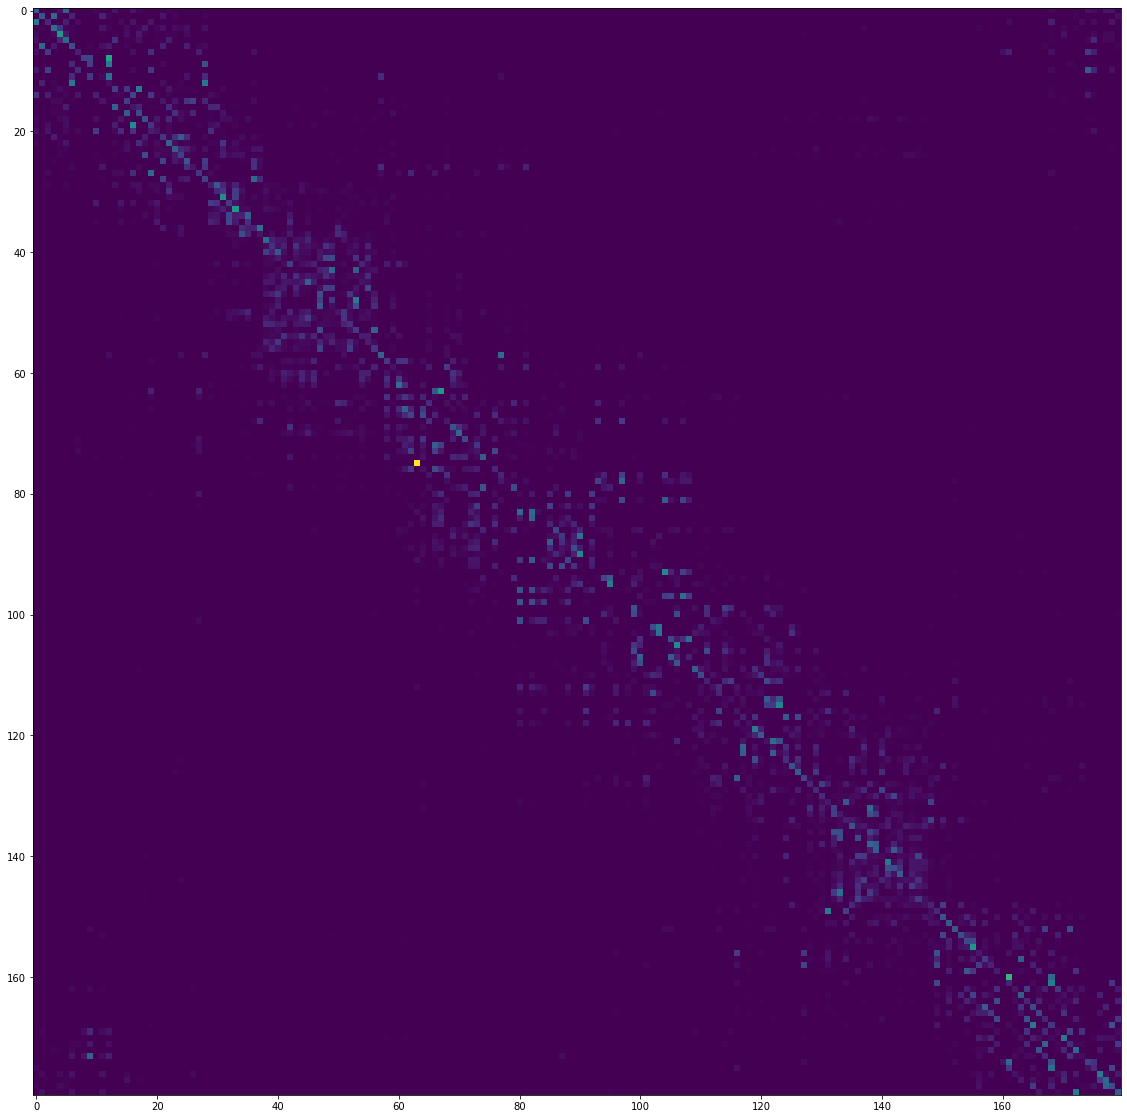

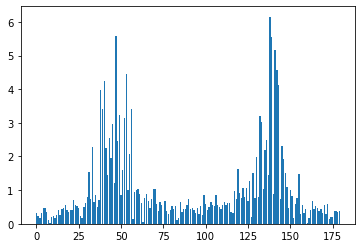

<BarContainer object of 180 artists>

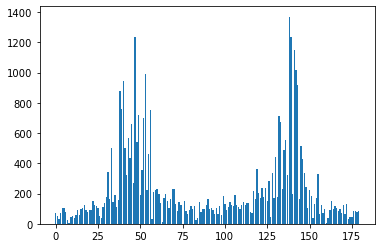

In [28]:
MK = np.zeros((kmeans.n_clusters, kmeans.n_clusters))
for s in range(1, len(labels)):
    label_now = labels[s]
    label_last = labels[s-1]
    MK[label_last, label_now] += 1
    
for s in range(n_clusters):
    MK[s, :] = MK[s, :]/np.sum(MK[s, :])

for s in range(n_clusters):
    MK[s, :] = MK[s, ords]

for s in range(n_clusters):
    MK[:, s] = MK[ords, s]

plt.figure(figsize=(20,20))
plt.imshow(MK[:,:])
arr = [0]*n_clusters
arr[0] = 1
plt.show()

u = [1]*n_clusters

for s in range(1000):
    u = np.dot(np.array(u), MK)

#print(u)
plt.bar(np.arange(n_clusters), u)
plt.show()
plt.bar(np.arange(n_clusters), nums[ords])

## 用 MK 產生序列

In [29]:
label_now = np.random.randint(n_clusters)
new_seq = [label_now]
video = cv2.VideoWriter("MKlarge_test.avi", cv2.VideoWriter_fourcc(*"MJPG"), 20, (cen_imgs[0].shape[0], cen_imgs[0].shape[1]), False)
for s in range(1000):
    print(cen_imgs[label_now].shape)
    video.write(cen_imgs[label_now].astype(np.uint8))
    
    #video.write(cen_imgs[labels[s]].astype(np.uint8))
    #video.write(imgs[s])
    ran = np.random.rand()
    n = 0
    temp = MK[label_now, n]
    while temp <= ran:
        n+=1
        temp += MK[label_now, n]
        if n >= n_clusters-1:
            n=0
            temp = MK[label_now, n]
            ran = np.random.rand()
    
            
    print(label_now, MK[label_now, n], n)
    label_now = n
    new_seq.append(label_now)
    
video.release()

(241, 241)
118 0.006172839506172839 149
(241, 241)
149 0.01904761904761905 128
(241, 241)
128 0.047619047619047616 101
(241, 241)
101 0.23863636363636365 80
(241, 241)
80 0.17094017094017094 88
(241, 241)
88 0.019801980198019802 67
(241, 241)
67 0.22549019607843138 64
(241, 241)
64 0.011834319526627219 54
(241, 241)
54 0.013452914798206279 58
(241, 241)
58 0.15311004784688995 61
(241, 241)
61 0.10101010101010101 54
(241, 241)
54 0.13452914798206278 41
(241, 241)
41 0.21442885771543085 48
(241, 241)
48 0.3966789667896679 53
(241, 241)
53 0.22796352583586627 47
(241, 241)
47 0.052588996763754045 56
(241, 241)
56 0.01456953642384106 45
(241, 241)
45 0.30851063829787234 45
(241, 241)
45 0.30851063829787234 45
(241, 241)
45 0.30851063829787234 45
(241, 241)
45 0.060790273556231005 41
(241, 241)
41 0.22244488977955912 49
(241, 241)
49 0.28172942817294283 47
(241, 241)
47 0.06067961165048544 43
(241, 241)
43 0.33274647887323944 49
(241, 241)
49 0.28172942817294283 47
(241, 241)
47 0.239482200

43 0.08450704225352113 47
(241, 241)
47 0.1553398058252427 52
(241, 241)
52 0.07857142857142857 41
(241, 241)
41 0.03807615230460922 43
(241, 241)
43 0.29401408450704225 53
(241, 241)
53 0.02330293819655522 68
(241, 241)
68 0.06832298136645963 68
(241, 241)
68 0.012422360248447204 78
(241, 241)
78 0.3387096774193548 97
(241, 241)
97 0.18487394957983194 104
(241, 241)
104 0.047619047619047616 121
(241, 241)
121 0.3567251461988304 122
(241, 241)
122 0.1308016877637131 124
(241, 241)
124 0.24152542372881355 119
(241, 241)
119 0.0684931506849315 126
(241, 241)
126 0.29537366548042704 126
(241, 241)
126 0.29537366548042704 126
(241, 241)
126 0.05693950177935943 137
(241, 241)
137 0.02786377708978328 119
(241, 241)
119 0.09041095890410959 120
(241, 241)
120 0.03398058252427184 102
(241, 241)
102 0.23008849557522124 102
(241, 241)
102 0.008849557522123894 113
(241, 241)
113 0.22142857142857142 102
(241, 241)
102 0.05309734513274336 120
(241, 241)
120 0.06310679611650485 110
(241, 241)
110 0.1

# reconstruct the position

## get the speed

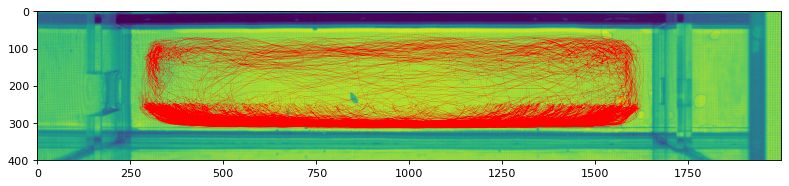

In [30]:
poses = np.array(poses)

plt.figure(figsize=(12, 6), dpi=80)
plt.plot(poses[:, 1], poses[:, 0], lw = 0.1, c='r')
plt.ylim([400,0])
plt.imshow(background)
velocity = (poses[1:]-poses[:-1])/2

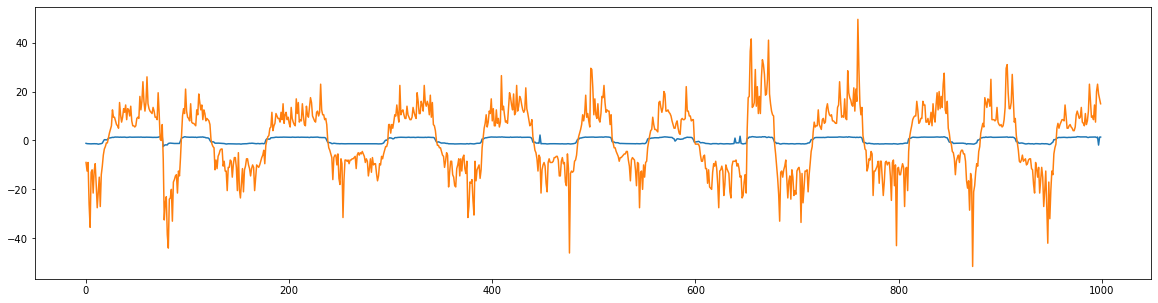

In [31]:
plt.figure(figsize=(20,5))
plt.plot(h_ans[8000:9000])
plt.plot(velocity[8000:9000, 1])

In [32]:
input_t = np.concatenate([np.expand_dims(labels[s:-3+s], axis=0) for s in range(3)], axis=0)
input_t = np.array([input_t[:, s] for s in range(input_t.shape[1])])
uq, ind = np.unique(input_t, axis=0, return_inverse=True)
v_t = velocity[2:]
print(ind.shape, v_t.shape)
print(len(uq))

for uni in range(len(uq)):
    temp = []
    for s, value in enumerate(ind):
        if value == uni:
            temp.append(np.linalg.norm(v_t[s]))
    print(uni, np.std(temp)/np.mean(temp))

(39997,) (39997, 2)
15026
0 0.5622951349968829
1 0.1284411087615849
2 0.0
3 0.0
4 0.0
5 0.2512345410118291
6 0.5814070792612763
7 0.0
8 0.9139931352483636
9 0.7606787958670651
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.041424344886624664
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.4924910723524583
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.2924235083393783
31 0.0
32 0.4567249804885606
33 0.42231114677872406
34 0.4124840769731123
35 0.0
36 0.0
37 0.0
38 0.31185014595043475
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.08464779155020699
47 0.5535531949447222
48 0.0
49 0.33333333333333337
50 0.0
51 0.0
52 0.0
53 0.0
54 0.18426923481364896
55 0.0
56 0.0
57 0.281051885451457
58 0.0
59 0.32539281787493
60 0.07904442055677413
61 0.0
62 0.0
63 0.0
64 0.581247742018557
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.31939571791564175
77 0.11059559712032609
78 0.0
79 0.1262841533958515
80 0.10452637824157711
81 0.0
82 0.0
83 0.2224445350284646

607 0.0
608 0.19578830818384757
609 0.3840192796427091
610 0.3704755900347928
611 0.0
612 0.6847608466860418
613 0.0
614 0.0
615 0.0
616 0.0
617 0.0
618 0.317631111816803
619 0.0
620 0.0
621 0.0
622 0.0
623 0.0
624 0.5470868832855842
625 0.0
626 0.0
627 0.0
628 0.0
629 0.0
630 0.0
631 0.0
632 0.0
633 0.0
634 0.0
635 0.09061756100986597
636 0.0
637 0.0
638 0.0
639 0.0
640 0.1891891891891892
641 0.0566821363340727
642 0.4851105482788438
643 0.0
644 0.0
645 0.026948231197301664
646 0.32284103587628704
647 0.17458501024567588
648 0.0
649 0.5644535453350328
650 0.34283406292179297
651 0.0
652 0.0
653 0.0
654 0.0
655 0.0
656 0.5341414438420039
657 0.0
658 0.35351280191142986
659 0.0
660 0.0
661 0.0
662 0.15643115578286754
663 0.0
664 0.5905804935993283
665 0.23622790706371666
666 0.17045337049037565
667 0.3992654287332287
668 0.0
669 0.0
670 0.4043045573402592
671 0.19656093807055208
672 0.2652093546824443
673 0.0
674 0.0
675 0.0
676 0.0
677 0.0
678 0.0
679 0.0
680 0.0
681 0.0
682 0.0
683 0.

1221 0.0
1222 0.3245893206505987
1223 0.0
1224 nan
1225 0.0
1226 0.0
1227 0.0
1228 0.0
1229 0.0
1230 0.0
1231 0.6901567218015424
1232 0.0
1233 0.0
1234 0.0
1235 0.0
1236 0.0
1237 0.0
1238 0.18694065380948569
1239 0.0
1240 0.5704646258684662
1241 0.0
1242 0.5851478478075647
1243 0.0
1244 0.0
1245 0.11866921498332274
1246 0.0
1247 0.0
1248 0.32342299500767424
1249 0.0
1250 0.3901998166268725
1251 0.37524459318566467
1252 0.0
1253 0.0


<ipython-input-32-8d62eeb95aa8>:13: RuntimeWarning: invalid value encountered in double_scalars
  print(uni, np.std(temp)/np.mean(temp))


1254 0.0
1255 0.0
1256 0.6939468294089125
1257 0.0
1258 0.0
1259 0.0
1260 0.0
1261 0.0
1262 0.0
1263 0.0
1264 0.03458573419155374
1265 0.0
1266 0.1810731292859338
1267 0.0
1268 0.21745289825881398
1269 0.3226000672584486
1270 0.0
1271 0.0
1272 0.0
1273 0.28565996728665155
1274 0.0
1275 0.0
1276 0.33406578064377807
1277 0.0
1278 0.4417478110437077
1279 0.0
1280 0.0
1281 0.2965563817425633
1282 0.0
1283 0.0
1284 0.0
1285 0.0
1286 0.06279179539239617
1287 0.0
1288 0.0
1289 0.0
1290 0.0
1291 0.0
1292 0.03153189250485195
1293 0.0
1294 0.5568524913546284
1295 0.29957878822263023
1296 0.0
1297 0.0
1298 0.0
1299 0.0
1300 0.0
1301 0.0
1302 0.054257620243768935
1303 0.019526962356404307
1304 0.14705899326262867
1305 0.0
1306 0.0
1307 0.07193549312789925
1308 0.0
1309 0.0
1310 0.0
1311 0.19167712556946118
1312 0.0
1313 0.0
1314 0.11734322008545622
1315 0.32388087436899676
1316 0.12843407277851607
1317 0.0
1318 0.0
1319 0.40366779191414265
1320 0.1875742290996887
1321 0.0
1322 0.0
1323 0.344678588

1821 0.0
1822 0.0
1823 0.0
1824 0.2479216598450128
1825 0.0
1826 0.25327273457704197
1827 0.0
1828 0.0
1829 0.0
1830 0.2172293133734459
1831 0.0
1832 0.13640147948634848
1833 0.0
1834 0.07614879283152282
1835 0.0
1836 0.0
1837 0.0
1838 0.11539347974368709
1839 0.0
1840 0.0
1841 0.15538666861030329
1842 0.0
1843 0.38120913554810554
1844 0.2872448655028603
1845 0.36376038139534334
1846 0.28948994087669017
1847 0.327061482983869
1848 0.21135336869333424
1849 0.32264320022042237
1850 0.0
1851 0.0
1852 0.5099288220984398
1853 0.0
1854 0.0
1855 0.37739092170964844
1856 0.0
1857 0.0
1858 0.35378948642347646
1859 0.0
1860 0.20078231274916986
1861 0.2762045919998471
1862 0.18507509624676224
1863 0.0
1864 0.0
1865 0.35484536518520843
1866 0.3284668785314298
1867 0.0
1868 0.0
1869 0.26257070103428987
1870 0.5373080230046626
1871 0.0
1872 0.29388022418563736
1873 0.04594833238916213
1874 0.20359655163490448
1875 0.4837068244050336
1876 0.07025200863250627
1877 0.0
1878 0.30255192992801144
1879 0.3

2406 0.0
2407 0.0
2408 0.5682162643417145
2409 0.0
2410 0.3196583585482182
2411 0.0
2412 0.0
2413 0.0
2414 0.0
2415 0.47869535530887586
2416 0.8947744890752062
2417 0.49055674910962876
2418 0.0
2419 0.0
2420 0.0
2421 0.0
2422 0.0
2423 nan
2424 0.0
2425 0.5840168069730438
2426 0.0
2427 0.0
2428 0.0
2429 0.0
2430 0.0
2431 0.0
2432 0.0
2433 0.0
2434 0.0
2435 0.0
2436 0.0
2437 0.0
2438 0.0
2439 0.0
2440 0.346218501112716
2441 0.30630788110585633
2442 0.2568482570134303
2443 0.15232340768439784
2444 0.0
2445 0.18968666782170301
2446 0.6633446307595993
2447 0.015370060406429848
2448 0.49157737159634446
2449 0.0
2450 0.0
2451 0.0
2452 0.36134346660356664
2453 0.0
2454 0.18968666782170301
2455 0.24017252277854179
2456 0.0
2457 0.37437764742531265
2458 0.0
2459 0.0
2460 0.013106822372251343
2461 0.0
2462 0.0
2463 0.0
2464 0.2660824757248498
2465 0.0
2466 0.0
2467 0.045081208461841195
2468 0.08640005218400337
2469 0.5449291777595371
2470 0.0
2471 0.0
2472 0.0
2473 0.29465171434249143
2474 0.0
24

2936 0.0
2937 0.6098209160587018
2938 0.19330278999525408
2939 0.19158867027676413
2940 0.3893033207258376
2941 0.0
2942 0.20531654986471418
2943 0.0
2944 0.057247324167932594
2945 0.06030434591375621
2946 0.3790451318676501
2947 0.5109232110389319
2948 0.5239861885281675
2949 0.0
2950 0.0
2951 0.0
2952 0.0
2953 0.0
2954 0.0
2955 0.0
2956 0.0
2957 0.7016658873389889
2958 0.06549716600574676
2959 0.0
2960 0.0
2961 0.37012607652422047
2962 0.3676735005698239
2963 0.7000702984844223
2964 0.0
2965 0.0
2966 0.5712824070313378
2967 0.0
2968 0.0
2969 0.5053037577530637
2970 0.0
2971 0.0
2972 0.5536835386423983
2973 0.0
2974 0.0
2975 0.0
2976 0.0
2977 0.2785046193154063
2978 0.0
2979 0.0
2980 0.0
2981 0.18594234433846438
2982 0.45802002041631873
2983 0.5673180470767579
2984 0.3006669627921947
2985 0.4409188851667057
2986 0.0
2987 0.31851963189148436
2988 0.0
2989 0.15514802678627948
2990 0.37546760145310903
2991 0.30327532413343883
2992 0.24664977600242816
2993 0.0
2994 0.0
2995 0.0
2996 0.0
2

3513 0.1810731292859338
3514 0.0
3515 0.0
3516 0.07210980397480846
3517 0.0
3518 0.0
3519 0.0
3520 0.5309461512763549
3521 0.03122625897138345
3522 0.0
3523 0.0
3524 0.0
3525 0.0
3526 0.253430226009437
3527 0.22146546796093278
3528 0.12020633971978156
3529 0.20846645970142014
3530 0.07106414942764777
3531 0.540117592758853
3532 0.7226809486198105
3533 0.2963798014160709
3534 0.0
3535 0.0
3536 0.6440321628466728
3537 0.0
3538 0.4174649777637648
3539 0.0
3540 0.09863742323967226
3541 0.0
3542 0.2038053132830163
3543 0.0
3544 0.5650804640516378
3545 0.0
3546 0.0
3547 0.0
3548 0.01988553616074806
3549 0.0
3550 0.0
3551 0.31589747691323367
3552 0.47545856573022316
3553 0.3114542450237646
3554 0.19115535088443658
3555 0.0
3556 0.1596063947463753
3557 0.3018698790744336
3558 0.0
3559 0.0
3560 0.0
3561 0.0
3562 0.0
3563 0.5182382165443349
3564 0.0
3565 0.0
3566 0.0
3567 0.0
3568 0.5109155039379427
3569 0.0
3570 0.1254446586641469
3571 0.30730474812008646
3572 0.0
3573 0.5353150233875141
3574 0

4060 0.0
4061 0.0
4062 0.08471580285305935
4063 0.0
4064 0.5064525479506531
4065 0.0
4066 0.0
4067 0.0
4068 0.0
4069 0.0
4070 0.0
4071 0.14285714285714285
4072 0.0
4073 0.41085015258895285
4074 0.29674259045118545
4075 0.0
4076 0.0
4077 0.08825266818271872
4078 0.0
4079 0.0
4080 0.0
4081 0.4064718799500424
4082 0.6301834489587246
4083 0.015154995058715605
4084 0.0
4085 0.0
4086 0.29674259045118545
4087 0.0
4088 0.31810136880142076
4089 0.554809522829559
4090 0.0
4091 0.0
4092 0.0
4093 0.9757094118947175
4094 0.6654198507163366
4095 0.0
4096 0.8379586053250015
4097 0.699033068528645
4098 0.38196601125010515
4099 0.048260287851800025
4100 0.0
4101 0.21396998478485252
4102 0.0
4103 0.8447229749544776
4104 0.0
4105 0.43654190661949366
4106 0.060830322920400005
4107 0.2735906344200283
4108 0.34673673057918136
4109 0.0
4110 0.46213314738228994
4111 0.0
4112 0.0
4113 0.6585960828442012
4114 0.0
4115 0.0
4116 0.0
4117 0.0
4118 0.0
4119 0.0
4120 0.0
4121 0.0
4122 0.0
4123 0.13063217155440623
41

4613 0.0
4614 0.1756253170026871
4615 0.4560651910011476
4616 0.0
4617 0.0
4618 0.0
4619 0.0
4620 0.0
4621 0.0
4622 0.0
4623 0.6029154708026422
4624 0.0
4625 0.24391587870457615
4626 0.0
4627 0.0
4628 0.27578315912176327
4629 0.0
4630 0.09167308680401601
4631 0.0
4632 0.0
4633 0.0
4634 0.0
4635 0.0
4636 0.0
4637 0.41831267882767564
4638 0.0
4639 0.0
4640 0.0
4641 0.0
4642 0.4598645478239604
4643 0.2600645930603788
4644 0.0
4645 0.0
4646 0.20227278775216373
4647 0.0
4648 0.0
4649 0.0
4650 0.0
4651 0.0
4652 0.0
4653 0.11866921498332277
4654 0.0
4655 0.0
4656 0.0
4657 0.5036827767316269
4658 0.0
4659 0.0
4660 0.0
4661 0.4574679673339027
4662 0.49697702834907503
4663 0.0
4664 0.0
4665 0.0
4666 0.0
4667 0.0
4668 0.0
4669 0.22620041341093303
4670 0.0
4671 0.0
4672 0.0
4673 0.23582894841632024
4674 0.0
4675 0.37550909949105477
4676 0.0
4677 0.0
4678 0.0
4679 0.0
4680 0.20356279698071725
4681 0.3749369000593406
4682 0.47759225007251704
4683 0.0
4684 0.0
4685 0.0
4686 0.4181738402333018
4687 0.

5195 0.0
5196 0.0
5197 0.0
5198 0.0
5199 0.0
5200 0.2586412887922735
5201 0.0
5202 0.0
5203 0.0
5204 0.0
5205 0.0
5206 0.1297065735044761
5207 0.0
5208 0.4716930013500521
5209 0.0
5210 0.5451187371593509
5211 0.41469937340081736
5212 0.0
5213 0.8871036496818088
5214 0.0
5215 0.0
5216 0.4751547249493213
5217 0.0
5218 0.3677550188704383
5219 0.0
5220 0.0
5221 0.4566203133726081
5222 0.0
5223 0.0
5224 0.0
5225 0.0
5226 0.0
5227 0.0
5228 0.0
5229 0.0
5230 0.0
5231 0.0
5232 0.0
5233 0.0
5234 0.0
5235 0.0
5236 0.3112813131687793
5237 0.10284637010805878
5238 0.0
5239 0.0
5240 0.0
5241 0.0
5242 0.0
5243 0.0
5244 0.0
5245 0.09769789141815023
5246 0.0
5247 0.10728128668654309
5248 0.0
5249 0.0
5250 0.0
5251 0.0
5252 0.60746022812854
5253 0.0
5254 0.0
5255 0.0
5256 0.13656102768756578
5257 0.03648575259628603
5258 0.0
5259 0.0
5260 0.0
5261 0.0
5262 0.0
5263 0.3745971658501295
5264 0.0
5265 0.0
5266 0.0
5267 0.29674259045118545
5268 0.0
5269 0.0
5270 0.09262463164786862
5271 0.0
5272 0.0
5273 0.

5762 0.0
5763 0.0
5764 0.0
5765 0.0
5766 0.0
5767 0.0
5768 0.45557058841642395
5769 0.0
5770 0.0
5771 0.0
5772 0.13675586323412425
5773 0.0
5774 0.0
5775 0.0
5776 0.16818774818317878
5777 0.1399429042173634
5778 0.0
5779 0.0
5780 0.0
5781 0.0
5782 0.0
5783 0.0
5784 0.2524817862141917
5785 0.16434292889547356
5786 0.0
5787 0.18371173070873836
5788 0.0
5789 0.15130830306112394
5790 0.0
5791 0.0
5792 0.0
5793 0.0
5794 0.0
5795 0.0
5796 0.0
5797 0.0
5798 0.056331868680172946
5799 0.0
5800 0.0
5801 0.33903371363671553
5802 0.0
5803 0.0
5804 0.0
5805 0.0
5806 0.0
5807 0.2777413322851604
5808 0.0
5809 0.16314590118546873
5810 0.0
5811 0.0
5812 0.0
5813 0.0
5814 0.0
5815 0.0
5816 0.0
5817 0.0
5818 0.0
5819 0.0
5820 0.0
5821 0.40366437188245347
5822 0.196050128622985
5823 0.0
5824 0.0
5825 0.0
5826 0.25596049638823715
5827 0.0
5828 0.1924203007973694
5829 0.13029833713396133
5830 0.0
5831 0.0
5832 0.19943293534414291
5833 0.17885041848766856
5834 0.3827020825710764
5835 0.1810397448928617
5836 

6347 0.0
6348 0.5490720490973274
6349 0.0
6350 0.0
6351 0.0
6352 0.46225292238536386
6353 0.0
6354 0.0
6355 0.0
6356 0.0
6357 0.0
6358 0.0
6359 0.29783111824129965
6360 0.0
6361 0.32746940726218693
6362 0.38422907022603514
6363 0.3832815840935737
6364 0.11381928821239096
6365 0.0
6366 0.0
6367 0.0
6368 0.0
6369 0.0
6370 0.0
6371 0.10582310186030257
6372 0.0
6373 0.48392448704844404
6374 0.0
6375 0.0
6376 0.0
6377 0.488628844679813
6378 0.0
6379 0.45917000733279706
6380 0.0
6381 0.0
6382 0.0
6383 0.0
6384 0.3
6385 0.0
6386 0.6078665781231075
6387 0.0
6388 0.47002262848754617
6389 0.0
6390 0.394039178070836
6391 0.0
6392 0.0
6393 0.31453546785790837
6394 0.5109807730892872
6395 0.31154959020803813
6396 0.31160421281821693
6397 0.0
6398 0.0
6399 0.0
6400 0.0
6401 0.0
6402 0.0
6403 0.0
6404 0.0
6405 0.0
6406 0.0
6407 0.0
6408 0.0
6409 0.2320385845227087
6410 0.0
6411 0.4583338369016929
6412 0.0
6413 0.0
6414 0.0
6415 0.0
6416 0.0
6417 0.0
6418 0.2971753110196248
6419 0.037037037037037035
6

6930 0.0
6931 0.0
6932 0.0
6933 0.0
6934 0.2819295558632004
6935 0.5111280122177072
6936 0.0
6937 0.2482705094832247
6938 0.06293485587391427
6939 0.0
6940 0.4141836786750207
6941 0.13397012392196284
6942 0.2582968441207739
6943 0.0
6944 0.0
6945 0.0
6946 0.0
6947 0.03891341749166588
6948 0.0
6949 0.04339607163420994
6950 0.0
6951 0.06659234522269113
6952 0.12611225813613455
6953 0.3925862586905758
6954 0.0
6955 0.0
6956 0.0
6957 0.0
6958 nan
6959 0.25262383855369336
6960 0.0
6961 0.0
6962 0.45591971503749057
6963 0.0
6964 0.3946985739324086
6965 0.29357820945985325
6966 0.6077808288643016
6967 0.0
6968 0.0
6969 0.29553526503034594
6970 0.0
6971 0.03703682684258919
6972 0.20018764653398657
6973 0.0
6974 0.0
6975 0.0
6976 0.0
6977 0.3433727660485764
6978 0.0
6979 0.0
6980 0.3300068627007643
6981 0.2758619630028218
6982 0.3059378790743288
6983 0.34990152187222956
6984 0.0
6985 0.0
6986 0.04469001585168939
6987 0.003067513526500719
6988 0.17673955290542329
6989 0.0
6990 0.0
6991 0.5614498

7499 0.0
7500 0.0
7501 0.0
7502 0.0
7503 0.0
7504 1.0
7505 0.3362636871445597
7506 0.0
7507 0.0
7508 0.0
7509 0.0
7510 0.0
7511 0.0
7512 0.016442800531879444
7513 0.0
7514 0.0
7515 0.4445566564096813
7516 0.0
7517 0.0
7518 0.0
7519 0.07987138396640546
7520 0.0
7521 0.0
7522 0.0
7523 0.0
7524 0.0
7525 0.0
7526 0.0
7527 0.0
7528 0.0
7529 0.3293635217917172
7530 0.17764340806085657
7531 0.0
7532 0.0
7533 0.0
7534 0.0
7535 0.0
7536 0.2065526233313928
7537 0.5168507024267434
7538 0.0
7539 0.0
7540 0.0
7541 0.43901503955724264
7542 0.7588954535754728
7543 0.0
7544 0.34483420283828414
7545 0.23331420565008348
7546 0.0
7547 0.0
7548 0.2801013496655109
7549 0.0
7550 0.0
7551 0.0
7552 0.0
7553 0.0
7554 0.0
7555 0.23534783160353365
7556 0.0
7557 0.0
7558 0.0
7559 0.0
7560 0.40240819176679943
7561 0.0
7562 0.0
7563 0.19593546656399696
7564 0.0722197866864257
7565 0.0
7566 0.0
7567 0.0
7568 0.12902403317167985
7569 0.0
7570 0.0
7571 0.0
7572 0.0
7573 0.058207598383149727
7574 0.0
7575 0.0
7576 0.0


8077 0.0
8078 0.0
8079 0.0
8080 0.0
8081 0.07854058880020266
8082 0.2841365239291573
8083 0.0
8084 0.10895736409759024
8085 0.0
8086 0.48752882094045136
8087 0.0
8088 0.0
8089 0.0
8090 0.3469166747832429
8091 0.06345529831069248
8092 0.4909607489151112
8093 0.3554136873573732
8094 0.0
8095 0.23443556292536255
8096 0.3739348606757425
8097 0.5234569078975058
8098 0.0
8099 0.4102714246084321
8100 0.6314842150953532
8101 0.23187437543416414
8102 0.452030829911332
8103 0.1502718523811489
8104 0.15210925766868147
8105 0.25528661620418514
8106 0.7175399856881056
8107 0.0
8108 0.4803616157304732
8109 0.45673827496153574
8110 0.0
8111 0.0
8112 0.0
8113 0.0
8114 0.0
8115 0.0
8116 0.0340897492995319
8117 0.05606294195091263
8118 0.0
8119 0.25845077143860207
8120 0.17784964199298167
8121 0.0
8122 0.0
8123 0.0
8124 0.0
8125 0.29674259045118545
8126 0.0
8127 0.3834085106759337
8128 0.0
8129 0.0
8130 0.7095734876813894
8131 0.0
8132 0.0
8133 0.0
8134 0.0
8135 0.0
8136 0.0
8137 0.0
8138 0.0
8139 0.0
8

8624 0.0
8625 0.0
8626 0.0
8627 0.2819789195190993
8628 0.0
8629 0.1572782561049319
8630 0.07299194211324447
8631 0.0
8632 0.3673790594339765
8633 0.2638376246433093
8634 0.08397815554773796
8635 0.4259921911369923
8636 0.0
8637 0.0
8638 0.3095768667998539
8639 0.1102295894079298
8640 0.5883211459964789
8641 0.09133914148505586
8642 0.0
8643 0.2923533891109002
8644 0.0
8645 0.0
8646 0.1934591129513313
8647 0.19461221132644602
8648 0.0
8649 0.29741718115775717
8650 0.3588643912710452
8651 0.0
8652 0.19697871146075044
8653 0.0
8654 0.3541091460694451
8655 0.0
8656 0.13018443623988432
8657 0.290493460948473
8658 0.0
8659 0.0
8660 0.0
8661 0.5041500610463453
8662 0.49284731206286675
8663 0.11060145620280845
8664 0.0
8665 0.0
8666 0.0
8667 0.0
8668 0.0
8669 0.4422833144051092
8670 0.0
8671 0.18014727922008003
8672 0.0
8673 0.23054001344898817
8674 0.24807691864133827
8675 0.5796237176333333
8676 0.0
8677 0.0
8678 0.0
8679 0.0
8680 0.0
8681 0.12611074958230348
8682 0.0
8683 0.0
8684 0.0
8685

9208 0.0
9209 0.0
9210 0.551033760623841
9211 0.4831662775627399
9212 0.0
9213 0.0
9214 0.0
9215 0.4234247054269722
9216 0.1440838018728538
9217 0.16410335575252627
9218 0.19300826659041503
9219 0.39757863444440045
9220 0.25741608449255454
9221 0.27812606572681664
9222 0.32786022121759617
9223 0.0
9224 0.15555555555555556
9225 0.0
9226 0.07248773744246936
9227 0.06336013880319952
9228 0.0
9229 0.0
9230 0.7920074281580981
9231 0.0
9232 0.42854086550934034
9233 0.0
9234 0.09570593535608457
9235 0.0
9236 0.0
9237 0.0
9238 0.0
9239 0.6383792949709056
9240 0.07871871435708225
9241 0.0011086488127518682
9242 0.0
9243 0.0
9244 0.2559171949139933
9245 0.35103823209471324
9246 0.0
9247 0.2029527350580379
9248 0.009599488352480782
9249 0.38493580058516164
9250 0.40339786462568317
9251 0.0
9252 0.0
9253 0.37780152327988287
9254 0.30873505294953624
9255 0.38852998627719343
9256 0.0939504049684952
9257 0.1720838724752735
9258 0.08282089859501308
9259 0.0
9260 0.531636346510767
9261 0.37065484354359

9769 0.0
9770 0.0
9771 0.0
9772 0.0
9773 0.0
9774 0.2354256691745598
9775 0.294988851867712
9776 0.0
9777 0.0
9778 0.0
9779 0.4442998397769
9780 0.3340866134029853
9781 0.0
9782 0.4925305741651882
9783 0.2950143975669686
9784 0.3153031680616456
9785 0.4185088917655009
9786 0.0
9787 0.0
9788 0.0
9789 0.0
9790 0.0
9791 0.0
9792 0.0
9793 0.0
9794 0.0
9795 0.0
9796 0.0
9797 0.03886419040545674
9798 0.001025291576783491
9799 0.0
9800 0.0
9801 0.0
9802 0.0
9803 0.0
9804 0.0
9805 0.0
9806 0.0
9807 0.27447722791736884
9808 0.0
9809 0.39864415705077305
9810 0.0
9811 0.3008188214822341
9812 0.0
9813 0.3593970535875689
9814 0.28849230784732177
9815 0.24127218336472292
9816 0.0
9817 0.0757267155419674
9818 0.0
9819 0.2879229983889997
9820 0.0
9821 0.0
9822 0.49921520249553314
9823 0.25916958343784063
9824 0.2828596527274257
9825 0.11087009569888788
9826 0.4624080932040348
9827 0.0
9828 0.0
9829 0.0
9830 0.0
9831 0.0
9832 0.0
9833 0.055728090000841196
9834 0.0
9835 0.0
9836 0.0
9837 0.2625685688022

10315 0.0
10316 0.18819230049092872
10317 0.0
10318 0.12203395019229248
10319 0.4657309632027568
10320 0.39605494778551076
10321 0.0
10322 0.0
10323 0.5653172960545472
10324 0.409607745636939
10325 0.46711698723617334
10326 0.3176510644788413
10327 0.0
10328 0.0
10329 0.0
10330 0.1949678615216539
10331 0.0
10332 0.0
10333 0.0
10334 0.10574451262219137
10335 0.0
10336 0.0
10337 0.0
10338 0.0943278375675773
10339 0.0
10340 0.0
10341 0.2146018950864609
10342 0.21386161810380158
10343 0.5176192256017583
10344 0.18972793599906587
10345 0.0
10346 0.0
10347 0.0
10348 0.0
10349 0.0
10350 0.14794066425627833
10351 0.0
10352 0.0
10353 0.0
10354 0.0
10355 0.0
10356 0.0
10357 0.08687512515203351
10358 0.4091948500987432
10359 0.0
10360 0.0
10361 0.15971641362964384
10362 0.0
10363 0.12265574497832561
10364 0.2831647128236363
10365 0.438768693126856
10366 0.446342378912816
10367 0.5223588245771518
10368 0.0
10369 0.4172401543146215
10370 0.0
10371 0.0354951813731419
10372 0.38041224131786416
10373 

10871 0.0
10872 0.06889263240666102
10873 0.0
10874 0.0
10875 0.09765920463965092
10876 0.10213818744841359
10877 0.24459353451992183
10878 0.0
10879 0.11751523719872498
10880 0.010690773076883176
10881 0.28755904355932477
10882 0.19805401050583057
10883 0.12626647435706106
10884 0.0
10885 0.0
10886 0.0
10887 0.15593795830860682
10888 0.0
10889 0.0
10890 0.3333333333333333
10891 0.0
10892 0.24602279993126241
10893 0.0
10894 0.38599555410811304
10895 0.15442131774401074
10896 0.705540033365041
10897 0.0
10898 0.42416029746601286
10899 0.0
10900 0.0
10901 0.6462217456603435
10902 0.07013294453476625
10903 0.15988648448590514
10904 0.0
10905 0.0
10906 0.45794219522870905
10907 0.0
10908 0.3653809068790223
10909 0.45656672688440125
10910 0.08796573486375107
10911 0.12116562406191346
10912 0.26229631667701664
10913 0.40062304284907435
10914 0.24834126603883536
10915 0.0
10916 0.4027465389964185
10917 0.0
10918 0.0720324847912762
10919 0.0
10920 0.18938578003644693
10921 0.0
10922 0.08255266

11404 0.0
11405 0.41005275946108954
11406 0.0
11407 0.0
11408 0.0
11409 0.0
11410 0.0
11411 0.0
11412 0.0
11413 0.28828215595460055
11414 0.0
11415 0.0
11416 0.0
11417 0.0
11418 0.29528964533985974
11419 0.44071093994539495
11420 0.4430111084212272
11421 0.13003718984060014
11422 0.0
11423 0.5642805823774388
11424 0.13093310348352802
11425 0.05790979006814785
11426 0.0
11427 0.0
11428 0.0
11429 0.0
11430 0.0
11431 0.16116595363357886
11432 0.2823298758939425
11433 0.35201513833597775
11434 0.0
11435 0.0
11436 0.0
11437 0.418335365549909
11438 0.20466542332727805
11439 0.0
11440 0.0
11441 0.5522950313603742
11442 0.06549716600574675
11443 0.0
11444 0.0
11445 0.0
11446 0.43144071094738146
11447 0.0
11448 0.0
11449 0.4632069778770697
11450 0.25569065004489094
11451 0.598097337052861
11452 0.17157287525380988
11453 0.0
11454 0.27041795216227266
11455 0.0
11456 0.35921513823825785
11457 0.061141417641699725
11458 0.0
11459 0.0
11460 0.6877637580747631
11461 0.6478556604161482
11462 0.129678

11923 0.0
11924 0.0
11925 0.0
11926 0.0
11927 0.0
11928 0.49057436542331956
11929 0.0
11930 0.0
11931 0.0
11932 0.0
11933 0.0
11934 0.0
11935 0.0
11936 0.0
11937 0.0
11938 0.0
11939 0.0
11940 0.0
11941 0.1806218377611592
11942 0.0
11943 0.0
11944 0.1953754617082004
11945 0.16686499167860297
11946 0.062068778836364205
11947 0.492563689800568
11948 0.35716158334727766
11949 0.0
11950 0.0
11951 0.34983389804246917
11952 0.0
11953 0.4639992965798866
11954 0.0
11955 0.0
11956 0.0
11957 0.0
11958 0.5451820580115184
11959 0.0
11960 0.0
11961 0.0
11962 0.0
11963 0.0
11964 0.0
11965 0.0
11966 0.0
11967 0.0
11968 0.17833145222036578
11969 0.0
11970 0.0
11971 0.0
11972 0.0
11973 0.0
11974 0.0
11975 0.0
11976 0.2435674506989779
11977 0.0
11978 0.10339437502041063
11979 0.3162074439016184
11980 0.0
11981 0.38250602135093886
11982 0.0
11983 0.0
11984 0.0
11985 0.14495863670476541
11986 0.0
11987 0.0
11988 0.0
11989 0.27884006755728125
11990 0.2434610961803044
11991 0.0
11992 0.0
11993 0.0
11994 0.12

12468 0.0
12469 0.0
12470 0.15456311324869518
12471 0.16284108493256882
12472 0.0
12473 0.33940802922181007
12474 0.0
12475 0.0
12476 0.0
12477 0.0
12478 0.0
12479 0.0
12480 0.5657414540893351
12481 0.5
12482 0.0
12483 0.0
12484 0.0
12485 0.12178571971266659
12486 0.2457001845806194
12487 0.368871581114307
12488 0.22514822655441377
12489 0.0
12490 0.0
12491 0.0
12492 0.0
12493 0.027293043005358963
12494 0.0
12495 0.0
12496 0.0
12497 0.16329626251010362
12498 0.0
12499 0.0
12500 0.23359510256857782
12501 0.0
12502 0.0
12503 0.0
12504 0.0
12505 0.0
12506 0.0
12507 0.0
12508 0.0
12509 0.09338200490712195
12510 0.2702297488034638
12511 0.0
12512 0.13934303069250936
12513 0.0
12514 0.0
12515 0.15252131376341763
12516 0.17362748482589754
12517 0.3115384442411935
12518 0.0
12519 0.0
12520 0.22868188902481443
12521 0.2776759244970751
12522 0.40056003622335834
12523 0.0
12524 0.0262648252242536
12525 0.17262352880771936
12526 0.41409267507192404
12527 0.34721924691257433
12528 0.0
12529 0.43208

12969 0.0
12970 0.2544502303664277
12971 0.1239891299277472
12972 0.1619136824617224
12973 0.3406509955634744
12974 0.0
12975 0.17110035104300375
12976 0.0
12977 0.0
12978 0.0
12979 0.0
12980 0.3473085343779901
12981 0.0
12982 0.5924046868014965
12983 0.0
12984 0.24249549236163567
12985 0.0
12986 0.0
12987 0.15818209941716616
12988 0.45170225157642996
12989 0.4346515343808059
12990 0.0
12991 0.0
12992 0.0
12993 0.3221618441831921
12994 0.48112026788532075
12995 0.5097023673555603
12996 0.0
12997 0.44750328405396783
12998 0.10348397243285483
12999 0.27350884442907847
13000 0.11263344541676974
13001 0.6733911668142637
13002 0.40609732738963955
13003 0.4720945569614812
13004 0.0
13005 0.0
13006 0.3007580606124556
13007 0.04228937862994443
13008 0.463897238016576
13009 0.5727319516081688
13010 0.5729822122111611
13011 0.1938414446696206
13012 0.26599744178391016
13013 0.39888876081205993
13014 0.0
13015 0.5487374044542052
13016 0.0
13017 0.45048242410285094
13018 0.08886440554111127
13019 

13465 0.14253375231745374
13466 0.0
13467 0.04795619222978642
13468 0.0167111093752646
13469 0.0
13470 0.0
13471 0.0022971024732307663
13472 0.3622374888933442
13473 0.0
13474 0.0
13475 0.283745674956504
13476 0.22125281145573508
13477 0.4473591977655175
13478 0.3682172474086478
13479 0.32500053884810004
13480 0.10424207690099045
13481 0.29873297292797335
13482 0.0
13483 0.1284411087615849
13484 0.0
13485 0.41720944507621627
13486 0.579434181911754
13487 0.2633479106529392
13488 0.26394302878498904
13489 0.4496415829432824
13490 0.452115298381924
13491 0.2095737163304162
13492 0.31722460302784455
13493 0.0
13494 0.3500296914113061
13495 0.04997253723087334
13496 0.0
13497 0.3033933079708249
13498 0.4149191890774239
13499 0.5534508951219251
13500 0.21617613011430148
13501 0.3560651522082119
13502 0.10554557836889625
13503 0.0
13504 0.19465396136578195
13505 0.26267193204160005
13506 0.06480400708915159
13507 0.0
13508 0.391876922090295
13509 0.10762358305809101
13510 0.2850673348160936


13969 0.0
13970 0.14468360449439555
13971 0.6660005291496676
13972 0.0
13973 0.0
13974 0.2711880911243975
13975 0.31382748718246656
13976 0.0
13977 0.475842747657881
13978 0.0
13979 0.4143112129012254
13980 0.0
13981 0.0
13982 0.0
13983 0.0020576218802629844
13984 0.0
13985 0.4045635203882394
13986 0.19514648881037375
13987 0.44212754145653305
13988 0.0
13989 0.0
13990 0.24368740041797923
13991 0.3884885754485732
13992 0.0
13993 0.0
13994 0.0
13995 0.0
13996 0.09090909090909091
13997 0.38607766702366403
13998 0.3710797143716694
13999 0.4247326975320964
14000 0.11076498401401365
14001 0.0
14002 0.0
14003 0.1001686369414926
14004 0.4342018856781294
14005 0.12242822974839096
14006 0.0
14007 0.0
14008 0.0
14009 0.0
14010 0.0
14011 0.02770855372498696
14012 0.0
14013 0.0
14014 0.0
14015 0.0
14016 0.0
14017 0.4167310366712486
14018 0.32999735194759905
14019 0.0
14020 0.0
14021 0.4360392895367553
14022 0.4563908659574755
14023 0.0
14024 0.300608234743297
14025 0.0
14026 0.13636363636363635
14

14519 0.0
14520 0.0
14521 0.0
14522 0.0
14523 0.0
14524 0.0
14525 0.11147670294914579
14526 0.0
14527 0.0
14528 0.0
14529 0.0
14530 0.0
14531 0.0
14532 0.0
14533 0.0
14534 0.4189839302377914
14535 0.2875521519360343
14536 0.0
14537 0.0
14538 0.3498105223953621
14539 0.0
14540 0.0
14541 0.0
14542 0.0
14543 0.4533110472709662
14544 0.21154013290786433
14545 0.0
14546 0.0
14547 0.0
14548 0.0
14549 0.0
14550 0.0
14551 0.0
14552 0.5330479243991377
14553 0.21944563684159873
14554 0.03840464281908791
14555 0.32005967800903573
14556 0.0
14557 0.0
14558 0.0
14559 0.0
14560 0.0
14561 0.0
14562 0.4140917400085248
14563 0.2797680047131532
14564 0.0
14565 0.34251358280737576
14566 0.5249006945079222
14567 0.0
14568 0.0
14569 0.0
14570 0.1564311557828675
14571 0.0
14572 0.4032528951304228
14573 0.0
14574 0.0
14575 0.11997924030693495
14576 0.0
14577 0.0
14578 0.24507347715954084
14579 0.37374229866751135
14580 0.0
14581 0.24537179033446718
14582 0.0
14583 0.0854332620662884
14584 0.5261052863195113


## 用kmeans 重新產生centers

In [39]:
from sklearn.cluster import KMeans

n_clusters = 23
pos_kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-11, n_init=40)
pos_kmeans.fit(pca_sks)
labels = pos_kmeans.predict(pca_sks)
centers = pos_kmeans.cluster_centers_

tails = []
for pcas in centers:
    sks = np.dot(pcas, pca.components_)
    sk = [np.array([0,-2])]
    for an in sks:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M, sk[0]))
    tails.append(sk[-1][0])
ords = np.argsort(tails)
inv_ords=np.arange(len(ords))
inv_ords[ords] = np.arange(len(ords))
print(ords)
print(inv_ords)
tails = np.sort(tails)

[ 5 11  2 14 10 20 18  3  7 16 12 22  0  9 17 13 19 15  8  6  1  4 21]
[12 20  2  7 21  0 19  8 18 13  4  1 10 15  3 17  9 14  6 16  5 22 11]


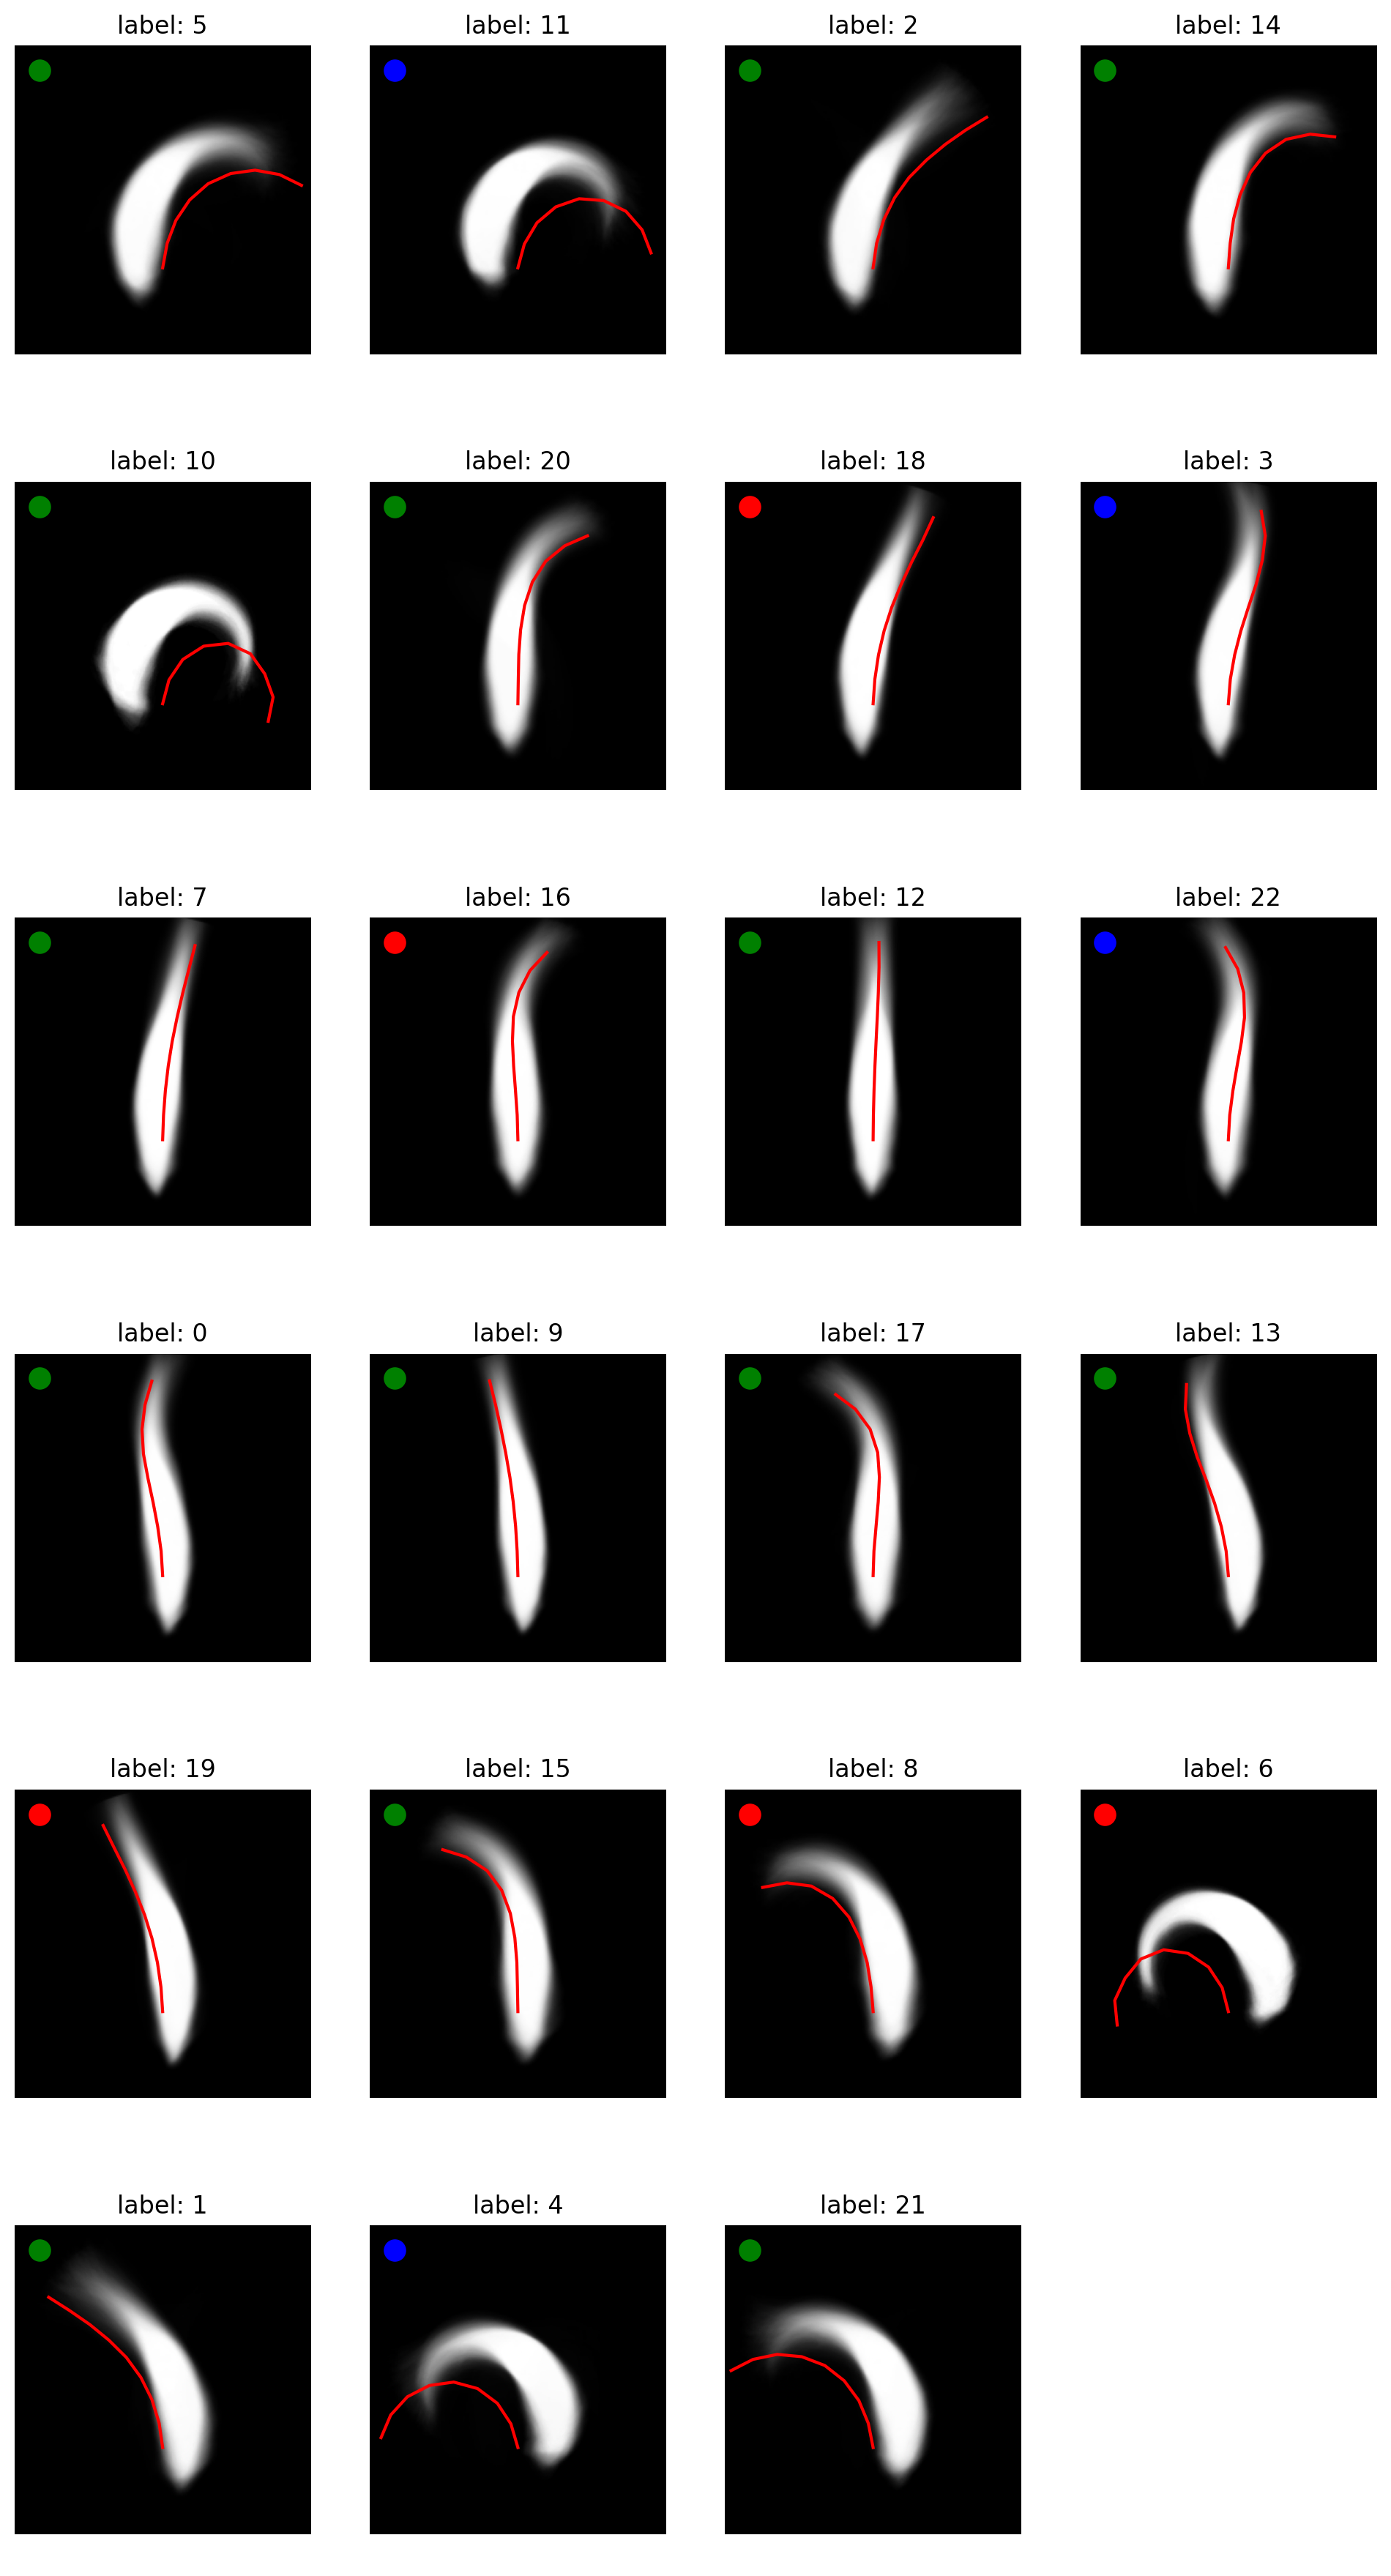

In [40]:

fig, axs = plt.subplots(pos_kmeans.n_clusters//4+1, 4, figsize=(12,1*pos_kmeans.n_clusters), dpi= 200)
ans = [list() for _ in range(pos_kmeans.n_clusters)]

nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
cen_imgs = np.zeros((n_clusters, imgs[0].shape[0], imgs[0].shape[1]), dtype='int')
for s, label in enumerate(labels):
    cen_imgs[label] += imgs[s]

for num, s in enumerate(ords):
    img = cen_imgs[s]
    cen_imgs[s] = (img/nums[s]).astype('uint8')
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    
    sks = np.dot(centers[s], pca.components_)
    sk = [np.array([0,2])]
    for an in sks:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M,sk[0]))
    sk = np.array(sk)
    
    fig = axs[num//4, num%4]
    
    fig.imshow(cen_imgs[s], plt.cm.gray, extent=[-12, 12, -5, 20]) 
    fig.title.set_text(f"label: {s}")
    fig.plot(sk[:,0], sk[:,1], c='red')
    fig.axis('Off')
    fig.scatter(-10, 18, s=100, color=color[s])

for s, _ in np.ndenumerate(axs):
     axs[s].axis('Off')

[0.15625    0.140625   0.11647727 0.37215909 0.03267045 0.12642045
 0.01420455 0.         0.         0.02272727 0.00284091 0.
 0.00284091 0.         0.00142045 0.         0.         0.00142045
 0.         0.         0.00426136 0.00284091 0.00284091]
[0.15625    0.140625   0.11647727 0.37215909 0.03267045 0.12642045
 0.01420455 0.         0.         0.02272727 0.00284091 0.
 0.00284091 0.         0.00142045 0.         0.         0.00142045
 0.         0.         0.00426136 0.00284091 0.00284091]


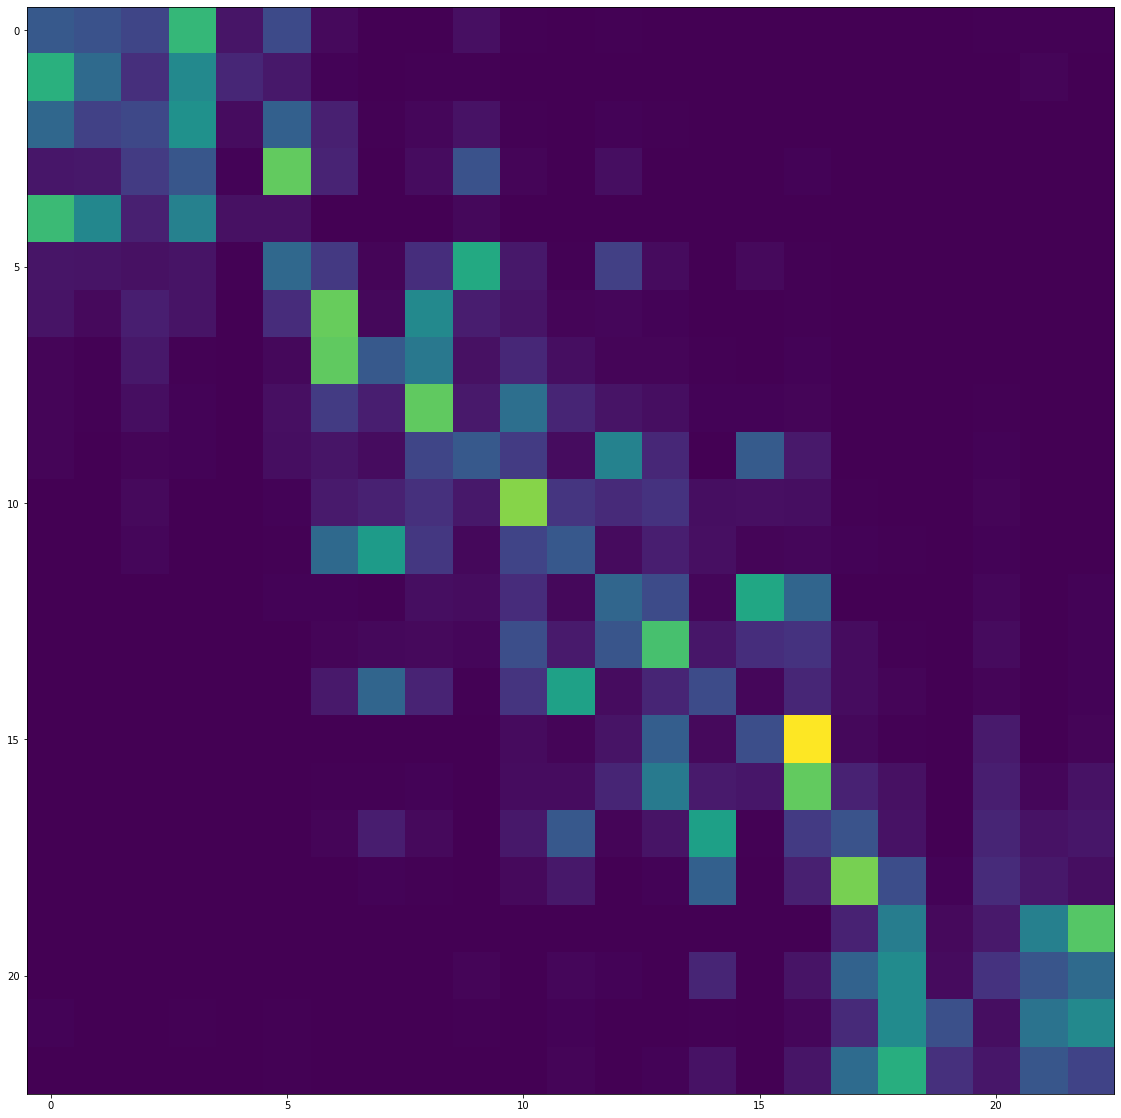

In [41]:
MK = np.zeros((pos_kmeans.n_clusters, pos_kmeans.n_clusters))
for s in range(1, len(labels)):
    label_now = labels[s]
    label_last = labels[s-1]
    
    MK[label_last, label_now] += 1
for s in range(pos_kmeans.n_clusters):
    MK[s, :] = MK[s, :]/np.sum(MK[s, :])

for s in range(pos_kmeans.n_clusters):
    MK[s, :] = MK[s, ords]

for s in range(pos_kmeans.n_clusters):
    MK[:, s] = MK[ords, s]

plt.figure(figsize=(20,20))
plt.imshow(MK[:,:])
arr = [0]*23
arr[0] = 1
print(np.dot(np.array(arr), MK))
print(MK[0,:])
plt.show()

## 黃老師的方法

### labels map to ords

In [62]:
# mapping label to ord
inv_labels = inv_ords[labels]
cen_imgs_mk = cen_imgs[ords]
background = np.zeros((500,2000), dtype=np.uint8)

-57.608653960352235 (120, 120)


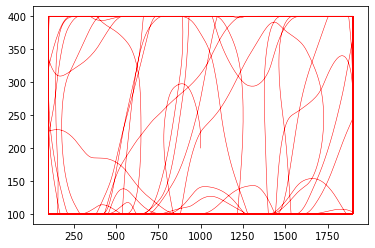

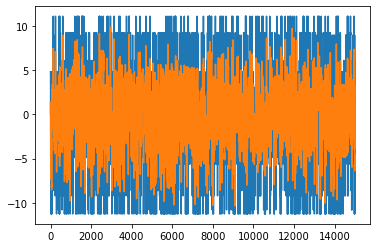

In [64]:
an_bins = np.linspace(-np.pi, np.pi, 13)

MKpath = "MKimg"
video = cv2.VideoWriter("MKtest_Hang.avi", cv2.VideoWriter_fourcc(*"MJPG"), 20, (background.shape[1], background.shape[0]), False)
cen_shape = cen_imgs[0].shape[0:2]

label_now = np.random.randint(n_clusters)
new_seq = [label_now]

win_len = 10
exp_mask = np.exp(-(win_len-np.arange(win_len))/win_len)
means = [0]

u = np.array([1, 0])
dt = 1/30

pos = [np.array([200, 1000])]
angle = [0]
v = 0
v_an = 0 # in pi
gamma = 1.5
gamma_an = 4
acc_v = 0
acc_an = 0


for s in range(15000):
    ran = np.random.rand()
    n = 0
    temp = MK[label_now, n]
    while temp <= ran:
        n+=1
        temp += MK[label_now, n]
        if n >= n_clusters-1:
            n=0
            temp = MK[label_now, n]
            ran = np.random.rand()
    
    #print(label_now, MK[label_now, n], n)
    label_now = n
    new_seq.append(int(label_now))
    
    if s <= win_len-2:
        temp = np.append([0]*(win_len-s-2),tails[new_seq[:]])
    else:
        temp = tails[new_seq[-win_len:]]
        
    ## from history len get movement
    mean = np.average(temp, weights=exp_mask)
    means.append(mean)
    acc = np.abs(temp[-1]-temp[-2])*200 if np.abs(temp[-1]-temp[-2])>1 else 0
    acc_an = (temp[-1])*np.abs(temp[-1])/5

    ## update the eq.

    
    pos_t = pos[-1] + v*np.dot(get_rot_M(angle[-1]), u)*dt
    angle_t = angle[-1] + v_an*dt
  

    if pos_t[0] >= 400:
        pos_t[0] = 400
    elif pos_t[0] < 100:
        pos_t[0] = 100
    if pos_t[1] >= 1900:
        pos_t[1] = 1900
    elif pos_t[1] < 100:
        pos_t[1] = 100
        
#     if pos_t[0] >= 400:
#         pos_t[0] = 0
#     elif pos_t[0] < 0:
#         pos_t[0] = 400
#     if pos_t[1] >= 2000:
#         pos_t[1] = 0
#     elif pos_t[1] < 0:
#         pos_t[1] = 2000


    
    pos.append(pos_t)
    angle.append(angle_t)
    
    #print(v)
    v = (-gamma*v + acc)*dt + v
    v_an = (-gamma_an*v_an + acc_an)*dt + v_an
    
    
    M = cv2.getRotationMatrix2D((cen_shape[1]//2, cen_shape[0]//2), angle_t/(np.pi)*180, 1)
    img = cen_imgs_mk[label_now].astype(np.uint8)
    #plt.imshow(img)
    img = cv2.warpAffine(img, M, cen_imgs[0].shape[0:2])
    img = glue_img(pos=(int(pos_t[0]), int(pos_t[1])), back=background, img=img)
    np.save(f"MKimg/frame_{s}", img)
    video.write(img)
    #print(pos_t)
plt.show()
print(angle_t, (cen_shape[1]//2, cen_shape[0]//2))
pos = np.array(pos)
angle = np.array(angle)
plt.plot(pos[:, 1], pos[:, 0], lw 
         = 0.5, c='r')
plt.show()

plt.plot(tails[new_seq])
plt.plot(means)

video.release()

# Locd the pca and kmeans from sideview-ver1

In [75]:
import pickle as pk

with open("sideview_pca.pkl", "rb") as file:
    pca = pk.load(file)
with open("side_pos_kmeans.pkl", "rb") as file:
    pos_kmeans = pk.load(file)

In [76]:
labels = pos_kmeans.predict(pca_sks)
centers = pos_kmeans.cluster_centers_

tails = []
for pcas in centers:
    sks = np.dot(pcas, pca.components_)
    sk = [np.array([0,-2])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,sk[0]))
    tails.append(sk[-1][0])
ords = np.argsort(tails)
inv_ords=np.arange(len(ords))
inv_ords[ords] = np.arange(len(ords))
print(ords)
print(inv_ords)
tails = np.sort(tails)

[ 6  5 10  7 19 15 20 12 18  0  1  8 14 16 22 17  3 11  9  4 13  2 21]
[ 9 10 21 16 19  1  0  3 11 18  2 17  7 20 12  5 13 15  8  4  6 22 14]


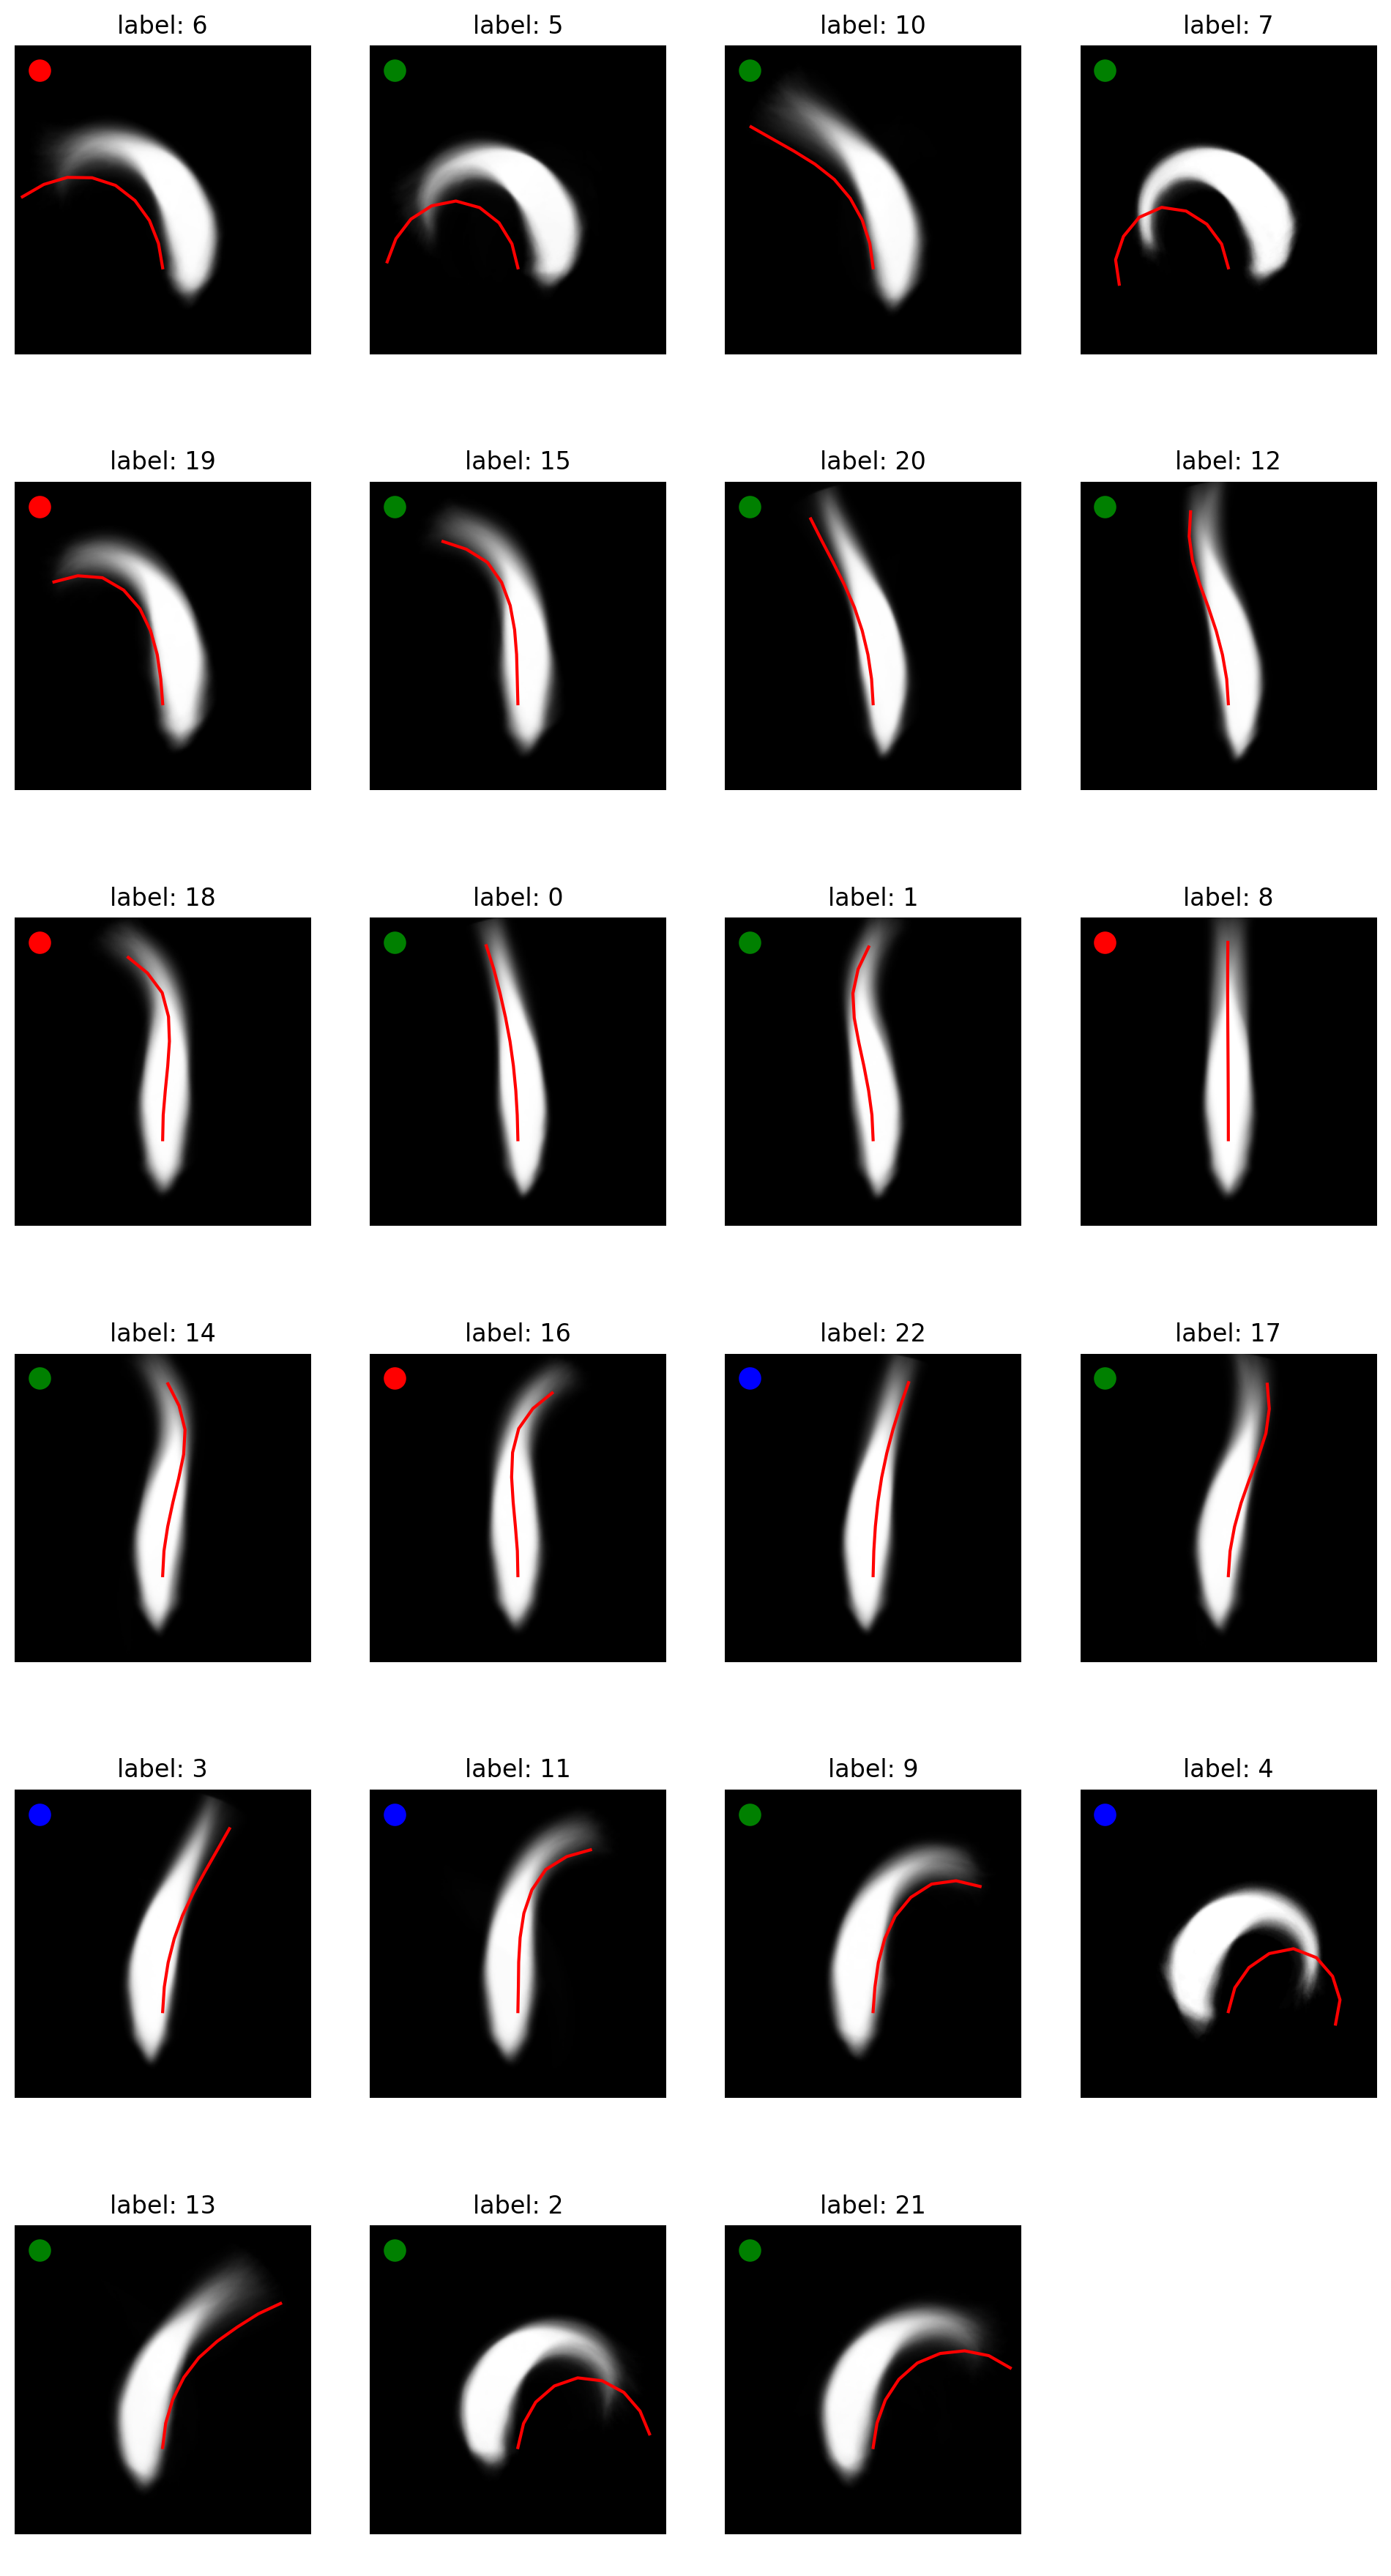

In [79]:

fig, axs = plt.subplots(pos_kmeans.n_clusters//4+1, 4, figsize=(12,1*pos_kmeans.n_clusters), dpi= 200)
ans = [list() for _ in range(pos_kmeans.n_clusters)]

nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
cen_imgs = np.zeros((n_clusters, imgs[0].shape[0], imgs[0].shape[1]), dtype='int')
for s, label in enumerate(labels):
    cen_imgs[label] += imgs[s]

for num, s in enumerate(ords):
    img = cen_imgs[s]
    cen_imgs[s] = (img/nums[s]).astype('uint8')
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    
    sks = np.dot(centers[s], pca.components_)
    sk = [np.array([0,2])]
    for an in sks:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M, sk[0]))
    sk = np.array(sk)
    
    fig = axs[num//4, num%4]
    
    fig.imshow(cen_imgs[s], plt.cm.gray, extent=[-12, 12, -5, 20]) 
    fig.title.set_text(f"label: {s}")
    fig.plot(sk[:,0], sk[:,1], c='red')
    fig.axis('Off')
    fig.scatter(-10, 18, s=100, color=color[s])

for s, _ in np.ndenumerate(axs):
     axs[s].axis('Off')

In [ ]:
MK = np.zeros((pos_kmeans.n_clusters, pos_kmeans.n_clusters))
for s in range(1, len(labels)):
    label_now = labels[s]
    label_last = labels[s-1]
    
    MK[label_last, label_now] += 1
for s in range(pos_kmeans.n_clusters):
    MK[s, :] = MK[s, :]/np.sum(MK[s, :])

for s in range(pos_kmeans.n_clusters):
    MK[s, :] = MK[s, ords]

for s in range(pos_kmeans.n_clusters):
    MK[:, s] = MK[ords, s]

plt.figure(figsize=(20,20))
plt.imshow(MK[:,:])
arr = [0]*23
arr[0] = 1
print(np.dot(np.array(arr), MK))
print(MK[0,:])
plt.show()